In [27]:
import sys
import os
import numpy as np
import pandas as pd
from dotenv import load_dotenv
load_dotenv()
import plotly_express as px
import os
from typing import Union
from datetime import datetime, timedelta
import pandas as pd

from omegaconf import OmegaConf
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from scipy.stats import zscore
cwd = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(cwd))
sys.path.append(parent_dir)

from src.data_management import get_data_by_dates
from src.scripts.research import create_model_decision_grid
from scipy.interpolate import griddata
from sklearn.preprocessing import LabelEncoder

from src.util import de_flatten_config, get_config
import kaleido
visual_folder = os.getenv("VISUALS")

In [15]:
# SUMMARY Results

files = ["delta_inventory_pnlreward_1684931119_summary_run_trades.csv", "delta_inventory_pnlreward_1684931119_summary_run_trades_as_comparison=False.csv"]

rename_dict = {
    files[0]: "Model",
    files[1]: "Expert"}

full_df = pd.DataFrame()
for i in files:
    df = pd.read_csv(f"/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/{i}")
    df['type'] = rename_dict[i]
    if full_df.empty:
        full_df = df
    else:
        full_df = pd.concat([full_df, df])
    
full_df['date'] = pd.to_datetime(full_df['date'])
full_df = full_df[(full_df.date != "2022-03-10") & (full_df.date != "2022-03-29") & (full_df.date != "2022-03-02")]
full_df['total_trades'] = full_df.bid_trade_count + full_df.ask_trade_count

full_df['limit_volume'] = full_df.bid_limit_volume + full_df.ask_limit_volume
full_df['market_volume'] = full_df.bid_market_volume + full_df.ask_market_volume
full_df['total_volume'] = full_df.limit_volume + full_df.market_volume
full_df['limit_volume_ratio'] = full_df.limit_volume / full_df.total_volume
full_df['limit_value'] = full_df.bid_limit_value + full_df.ask_limit_value
full_df['market_value'] = full_df.bid_market_value + full_df.ask_market_value


fig1 = px.line(full_df, x='date', y=['total_trades'], color="type")
fig2 = px.line(full_df, x='date', y=['max_inventory'], color="type")
fig3 = px.line(full_df, x='date', y=['mean_abs_inv'], color="type")
fig4 = px.line(full_df, x='date', y=['episode_return'], color="type")
fig5 = px.line(full_df, x='date', y=['drawdown'], color="type")
fig6 = px.line(full_df, x='date', y=['limit_volume_ratio'], color="type")




# fig1.write_image(os.path.join(visual_folder, 'trades_plot.png'))
# fig2.write_image(os.path.join(visual_folder, 'max_inventory_plot.png'))
# fig3.write_image(os.path.join(visual_folder, 'mean_abs_inv_plot.png'))
# fig4.write_image(os.path.join(visual_folder, 'episode_return_plot.png'))
# fig5.write_image(os.path.join(visual_folder, 'drawdown_plot.png'))

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
fig6.show()




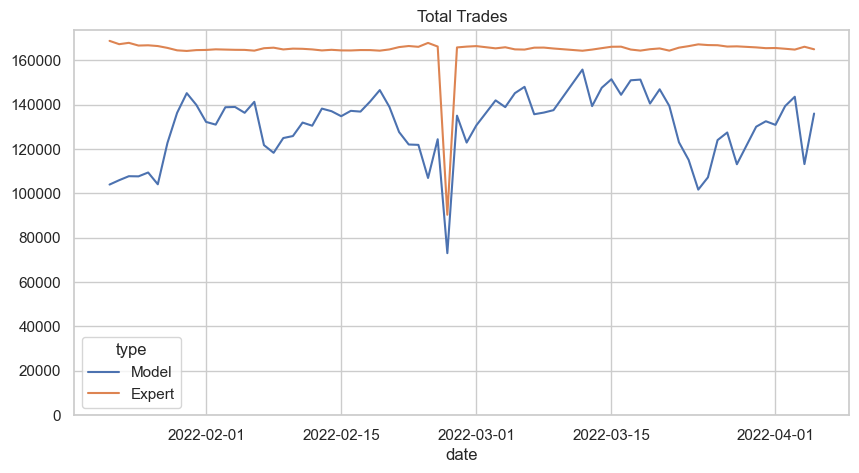

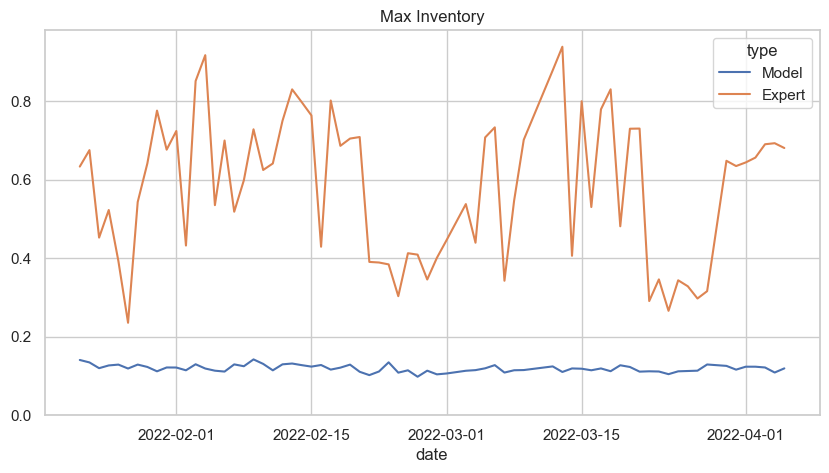

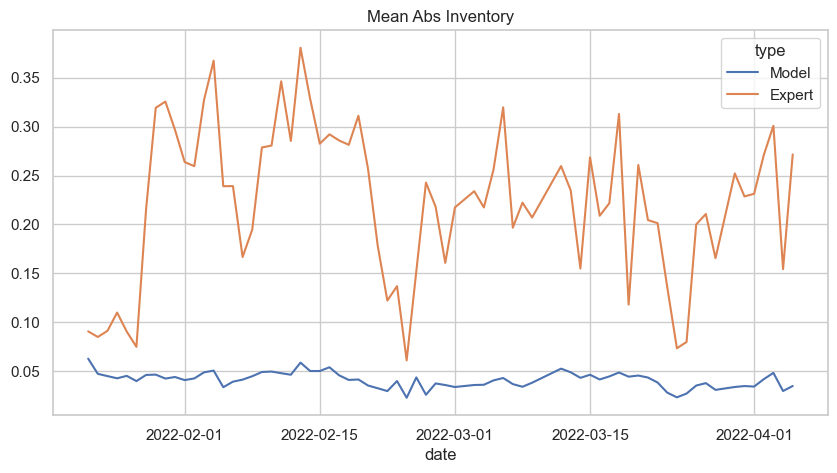

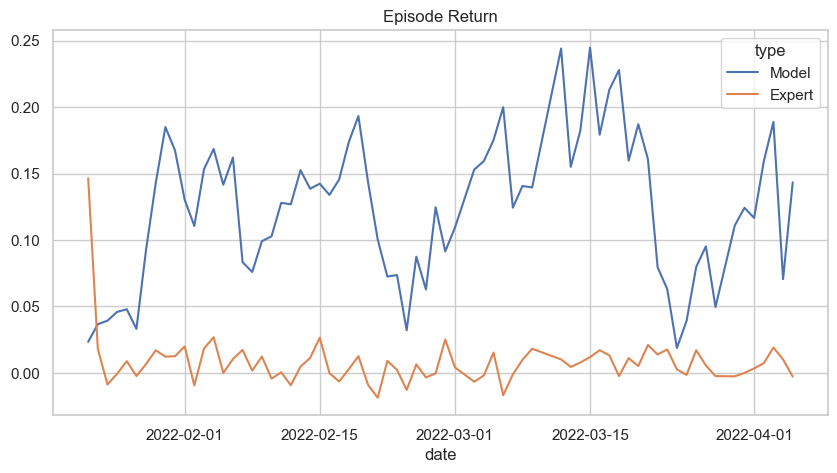

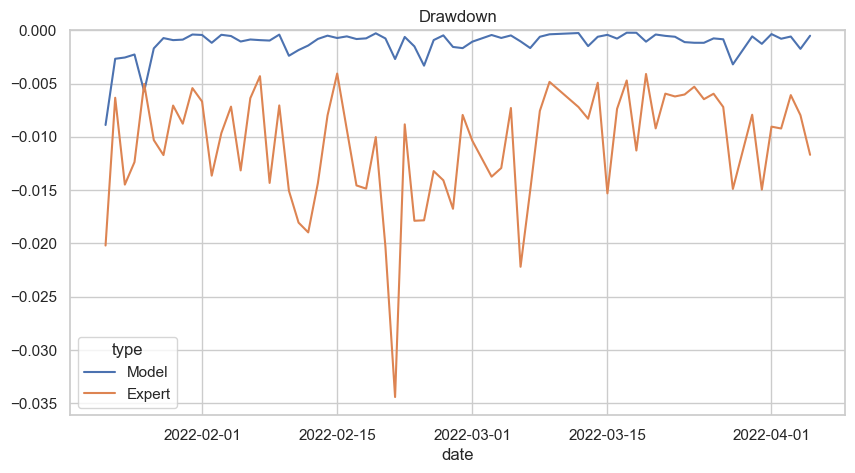

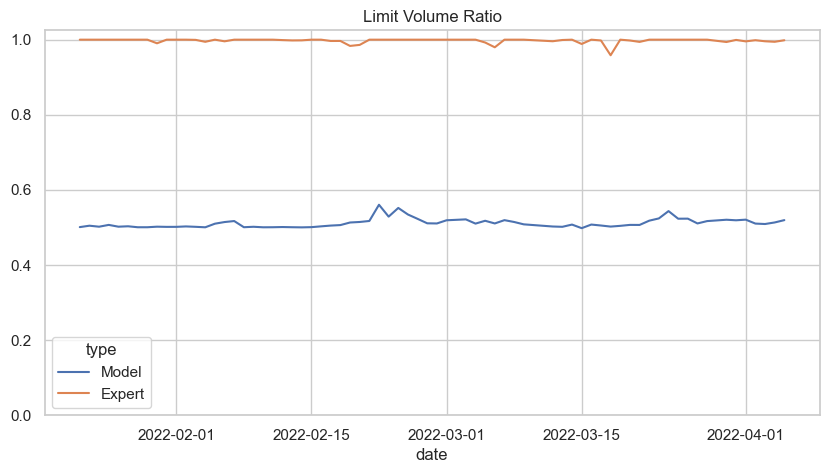

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style to whitegrid for uniformity
sns.set(style='whitegrid')

# List of plot variables and titles
plot_vars = ['total_trades', 'max_inventory', 'mean_abs_inv', 'episode_return', 'drawdown', 'limit_volume_ratio']
plot_titles = ['Total Trades', 'Max Inventory', 'Mean Abs Inventory', 'Episode Return', 'Drawdown', 'Limit Volume Ratio']

# List of plot variables that should start y-axis at 0
start_zero_vars = ['total_trades', 'max_inventory', 'limit_volume_ratio']

# Iterate over variables and titles to create each plot
for var, title in zip(plot_vars, plot_titles):
    fig, ax = plt.subplots(figsize=(10, 5)) # Individual subplots for each plot
    sns.lineplot(data=full_df, x='date', y=var, hue='type', ax=ax)
    ax.set_title(title)
    ax.set_ylabel('') # Remove y-axis title
    if var in start_zero_vars:  # if variable in the start_zero_vars list, set y-axis to start at 0
        ax.set_ylim(bottom=0)
    if var == 'drawdown':
        ax.set_ylim(top=0)
    plt.show()
    fig.savefig(os.path.join(visual_folder, f'{title.replace(" ", "_").lower()}_plot.png')) # Save each plot as a separate png file


In [19]:
full_df['bid_market_count'] = full_df.bid_trade_count - full_df.bid_limit_count
full_df['ask_market_count'] = full_df.ask_trade_count - full_df.ask_limit_count
full_df['bid_limit_share'] = full_df.bid_limit_count / full_df.bid_trade_count
full_df['bid_market_share'] = full_df.bid_market_count / full_df.bid_trade_count
full_df['ask_limit_share'] = full_df.ask_limit_count / full_df.ask_trade_count
full_df['ask_market_share'] = full_df.ask_market_count / full_df.ask_trade_count
full_df['bid_hit_ratio'] = full_df.bid_limit_hit_count / full_df.bid_limit_count
full_df['ask_hit_ratio'] = full_df.ask_limit_hit_count / full_df.ask_limit_count
full_df['volume'] = full_df.bid_limit_volume + full_df.ask_limit_volume + full_df.bid_market_volume + full_df.ask_market_volume

col_rename = {
    "bid_trade_count": "Buy trade count",
    "ask_trade_count": "Sell trade count",
    "volume": "Total volume",
    "bid_limit_share": "% of buy trades limit",
    "ask_limit_share": "% of sell trades limit",
    "bid_limit_value": "Value of buy limit trades",
    "ask_limit_value": "Value of sell limit trades",
    "bid_market_value": "Value of buy market trades",
    "ask_market_value": "Value of sell market trades",
    "bid_hit_ratio": "% of buy limit orders hit",
    "ask_hit_ratio": "% of sell limit orders hit"
}

formatted_df = full_df.groupby("type").mean()[list(col_rename.keys())].rename(columns=col_rename).T[['Model', 'Expert']]

format_dict = {
    'Buy trade count': "{:.0f}",
    'Sell trade count': "{:.0f}",
    'Total volume': "{:.0f}",
    '% of buy trades limit': "{:.2%}",
    '% of sell trades limit': "{:.2%}",
    'Value of buy limit trades': "{:.2f}",
    'Value of sell limit trades': "{:.2f}",
    'Value of buy market trades': "{:.2f}",
    'Value of sell market trades': "{:.2f}",
    '% of buy limit orders hit': "{:.2%}",
    '% of sell limit orders hit': "{:.2%}"
}

formatted_df.T.style.format(format_dict)


,Buy trade count,Sell trade count,Total volume,% of buy trades limit,% of sell trades limit,Value of buy limit trades,Value of sell limit trades,Value of buy market trades,Value of sell market trades,% of buy limit orders hit,% of sell limit orders hit
type,,,,,,,,,,,
Model,82205,48045,270206,100.00%,6.35%,132.89,0.17,-0.00,-6.14,16.46%,39.07%
Expert,82208,82208,94221,100.00%,99.82%,13.43,5.60,0.00,-0.01,28.72%,28.44%


In [18]:
full_df['volume'] = full_df.bid_limit_volume + full_df.ask_limit_volume + full_df.bid_market_volume + full_df.ask_market_volume

In [4]:
# Crossing the spread

df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full.csv")
max_diff = 0.0001 * 10
decimals = 4
df['bid_actual'] = df.mid_price + np.round(df.bid * max_diff, decimals)
df['ask_actual'] = df.mid_price + np.round(df.ask * max_diff, decimals)
order_df = df[['bid_actual',"bid", 'ask_actual',"ask", "mid_price", "bid_size", "ask_size"]]
order_df['bid_limit'] = (order_df.bid < 0) & (order_df.bid_size != 0)
order_df['ask_limit'] = (order_df.ask > 0) & (order_df.ask_size != 0)


bid_limit = order_df['bid_limit'].sum()
ask_limit = order_df['ask_limit'].sum()
total_limit = bid_limit + ask_limit
total_orders = len(order_df) * 2
print(f"limit bid: {bid_limit}, limit ask {ask_limit}, total limit {total_limit}, total orders {total_orders}, limit ratio {total_limit / total_orders}")
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

limit bid: 5754471, limit ask 239561, total limit 5994032, total orders 11509158, limit ratio 0.5208054316397429


/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_32636/728562430.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_df['bid_limit'] = (order_df.bid < 0) & (order_df.bid_size != 0)
/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_32636/728562430.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_df['ask_limit'] = (order_df.ask > 0) & (order_df.ask_size != 0)


/var/folders/7t/0_l8zk3s4w3bj0r9k4v9418w0000gn/T/ipykernel_32636/3120248666.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



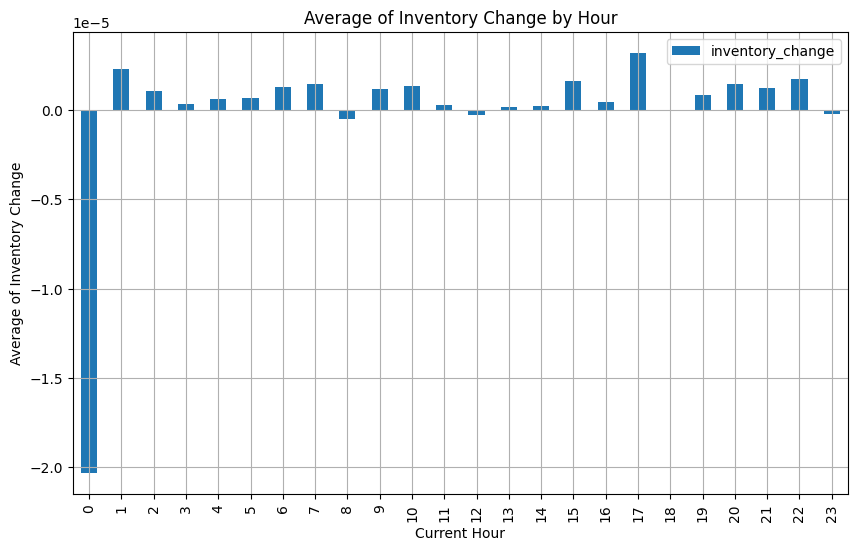

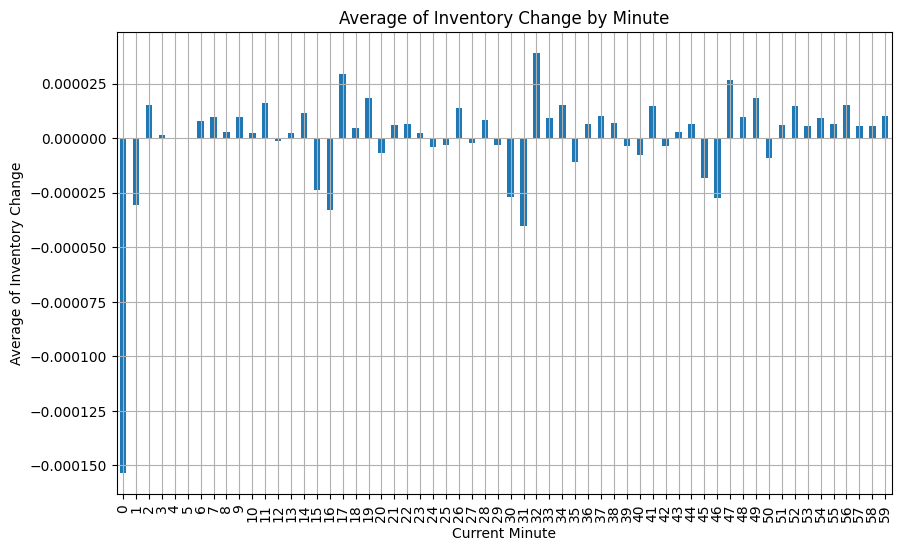

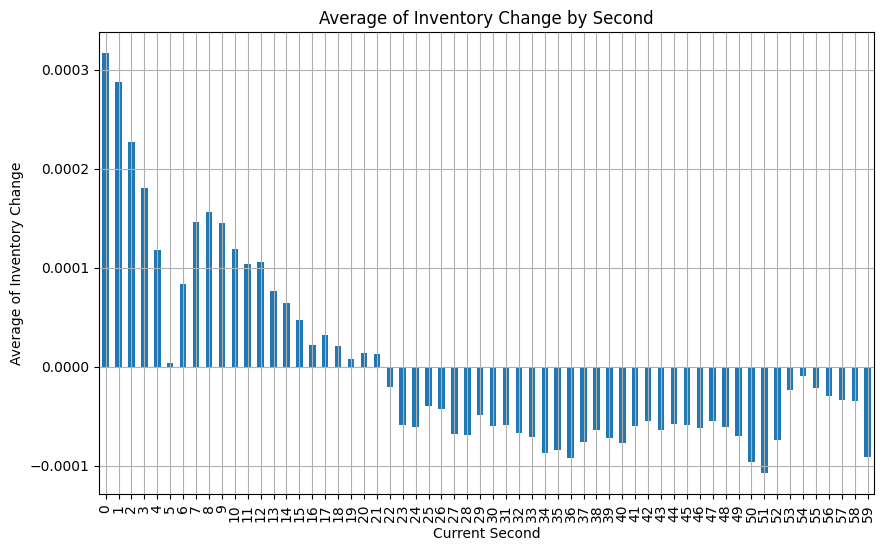

In [24]:
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/testing/delta_inventory_pnlreward_1684931119_full.csv")
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')

# --------------------Inventory net change by hour--------------------
df['current_hour'] = df.datetime.dt.hour
hour_df = df[['current_hour', 'inventory_values']]
hour_df['inventory_change'] = hour_df.inventory_values.diff()
inventory_change_sum = hour_df[['current_hour', 'inventory_change']].groupby('current_hour').mean()

inventory_change_sum.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Hour')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Hour')
plt.grid(True)
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_hour.png'))
plt.show()

# --------------------Inventory net change by minute--------------------
df_copy = df.copy() # Copy the dataframe for safety
df_copy['current_minute'] = df_copy.datetime.dt.minute
df_copy['inventory_change_minute'] = df_copy.inventory_values.diff()
inventory_change_sum_minute = df_copy.groupby('current_minute')['inventory_change_minute'].mean()

inventory_change_sum_minute.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Minute')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Minute')
plt.grid(True)
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_minute.png'))
plt.show()

# --------------------Inventory net change by second--------------------
df_copy['current_second'] = df_copy.datetime.dt.second
df_copy['inventory_change_second'] = df_copy.inventory_values.diff()
inventory_change_sum_second = df_copy.groupby('current_second')['inventory_change_second'].mean()

inventory_change_sum_second.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Current Second')
plt.ylabel('Average of Inventory Change')
plt.title('Average of Inventory Change by Second')
plt.grid(True)
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_second.png'))
plt.show()



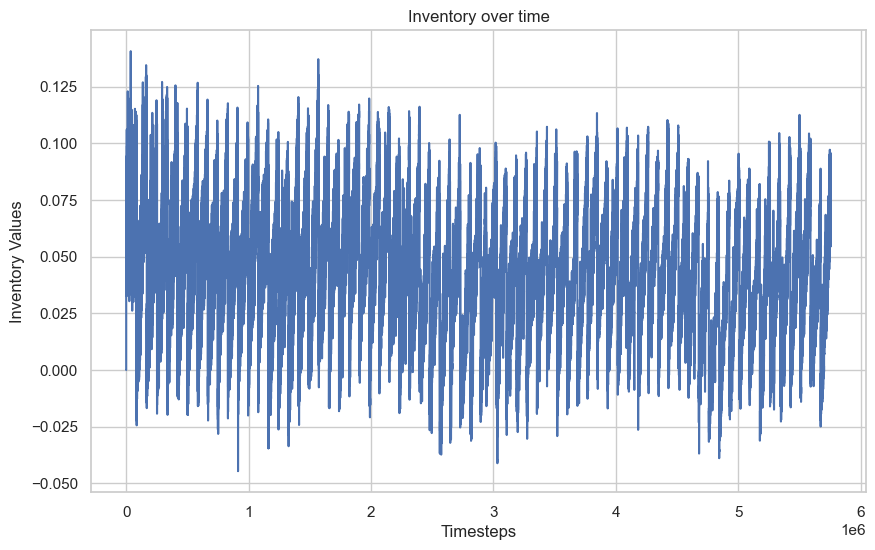

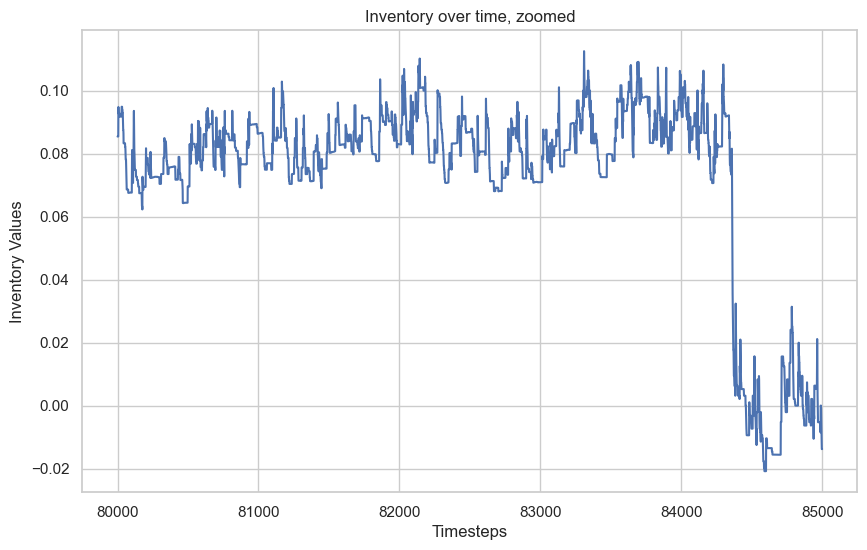

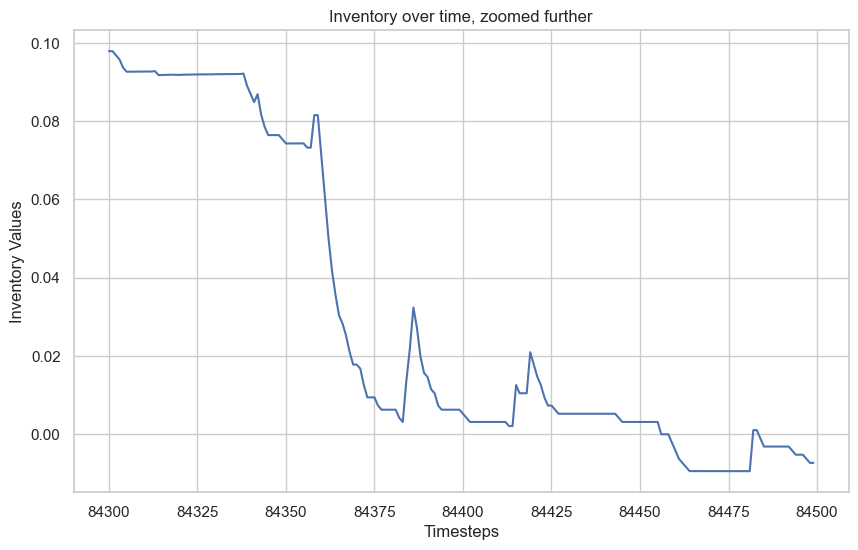

In [64]:
# inventory_values
plt.figure(figsize=(10, 6))
plt.xlabel('Timesteps')
plt.ylabel('Inventory Values')
plt.title('Inventory over time')
plt.grid(True)
plt.plot(df.index, df['inventory_values'], label='Inventory over time')
plt.savefig(os.path.join(visual_folder, 'inventory_over_time.png'))
plt.show()

# inventory values zoomed
plt.figure(figsize=(10, 6))
plt.xlabel('Timesteps')
plt.ylabel('Inventory Values')
plt.title('Inventory over time, zoomed')
plt.grid(True)
zoom = [80000, 85_000]
plt.plot(df.iloc[zoom[0]:zoom[1]].index, df.iloc[zoom[0]:zoom[1]]['inventory_values'], label='Inventory over time')
plt.savefig(os.path.join(visual_folder, 'inventory_over_time_zoomed_1.png'))
plt.show()

# inventory values zoomed further
plt.figure(figsize=(10, 6))
plt.xlabel('Timesteps')
plt.ylabel('Inventory Values')
plt.title('Inventory over time, zoomed further')
plt.grid(True)
zoom = [84_300, 84_500]
plt.plot(df.iloc[zoom[0]:zoom[1]].index, df.iloc[zoom[0]:zoom[1]]['inventory_values'], label='Inventory over time')
plt.savefig(os.path.join(visual_folder, 'inventory_over_time_zoomed_2.png'))
plt.show()

In [23]:
# # OLD matrix plot

# fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # 4 rows and 2 columns

# variables = ["intensity", "volatility", "osi", "order_book_imbalance"]
# titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

# for i, var in enumerate(variables):
#     for j, col in enumerate(["values", "inventory"]):
#         df_copy = df.copy()
#         df_copy[f'{var}_bins'] = pd.cut(df_copy[var], bins=10)
#         df_copy['value_change'] = df_copy[col].diff()
#         binned_value_change_sum = df_copy.groupby(f'{var}_bins')['value_change'].mean()
        
#         axs[i, j].bar(binned_value_change_sum.index.astype(str), binned_value_change_sum)
#         axs[i, j].grid(True)
#         axs[i, j].set_xticklabels([])  # Remove x-axis values
#         axs[i, j].set_yticklabels([])  # Remove y-axis values

# # fontfamily = 'serif'  # Set the font family
# fontsize = 20  # Set the font size

# for ax, col in zip(axs[0], ['Values', 'Inventory']):
#     ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
#                 xycoords='axes fraction', textcoords='offset points',
#                 size=fontsize, 
#                 # fontfamily=fontfamily,
#                 weight="bold", ha='center', va='baseline')  # Increased font size

# for ax, row in zip(axs[:,0], titles):
#     ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
#                 xycoords=ax.yaxis.label, textcoords='offset points',
#                 size=fontsize, 
#                 # fontfamily=fontfamily,
#                 weight="bold", ha='right', va='center')  # Increased font size

# fig.tight_layout()
# # plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables.png'))
# plt.show()


In [32]:
# def plot_diff_by_bins(df, column, diff_column, bins, title, y_label, x_label):
#     # Create bins for the specified column
#     df_copy = df.copy()
#     df_copy[f'{column}_bins'] = pd.cut(df_copy[column], bins=bins)

#     # Compute the difference in 'values'
#     df_copy['value_change'] = df_copy[diff_column].diff()

#     # Group by the bins and compute the sum
#     binned_value_change_sum = df_copy.groupby(f'{column}_bins')['value_change'].mean()

#     # Plot the result
#     binned_value_change_sum.plot(kind='bar', figsize=(10, 6))
#     plt.xlabel(x_label)
#     plt.ylabel(y_label)
#     plt.title(title)
#     plt.grid(True)
#     plt.show()


# plot_diff_by_bins(df, "intensity", "values",10, "Mean of Value Change by Intensity", "Mean of Value Change", "Intensity")
# plot_diff_by_bins(df, "intensity", "inventory",10, "Mean of Inventory Change by Intensity", "Mean of Inventory Change", "Intensity")

# plot_diff_by_bins(df, "volatility", "values",10, "Mean of Value Change by Volatility", "Mean of Value Change", "Volatility")
# plot_diff_by_bins(df, "volatility", "inventory",10, "Mean of Inventory Change by Volatility", "Mean of Inventory Change", "Volatility")

# plot_diff_by_bins(df, "osi", "values",10, "Mean of Value Change by OSI", "Mean of Value Change", "OSI")
# plot_diff_by_bins(df, "osi", "inventory",10, "Mean of Inventory Change by OSI", "Mean of Inventory Change", "OSI")


# plot_diff_by_bins(df, "order_book_imbalance", "values",10, "Mean of Value Change by Order book imbalance", "Mean of value Change", "Order book imbalance")
# plot_diff_by_bins(df, "order_book_imbalance", "inventory",10, "Mean of Inventory Change by Order book imbalance", "Mean of Inventory Change", "Order book imbalance")


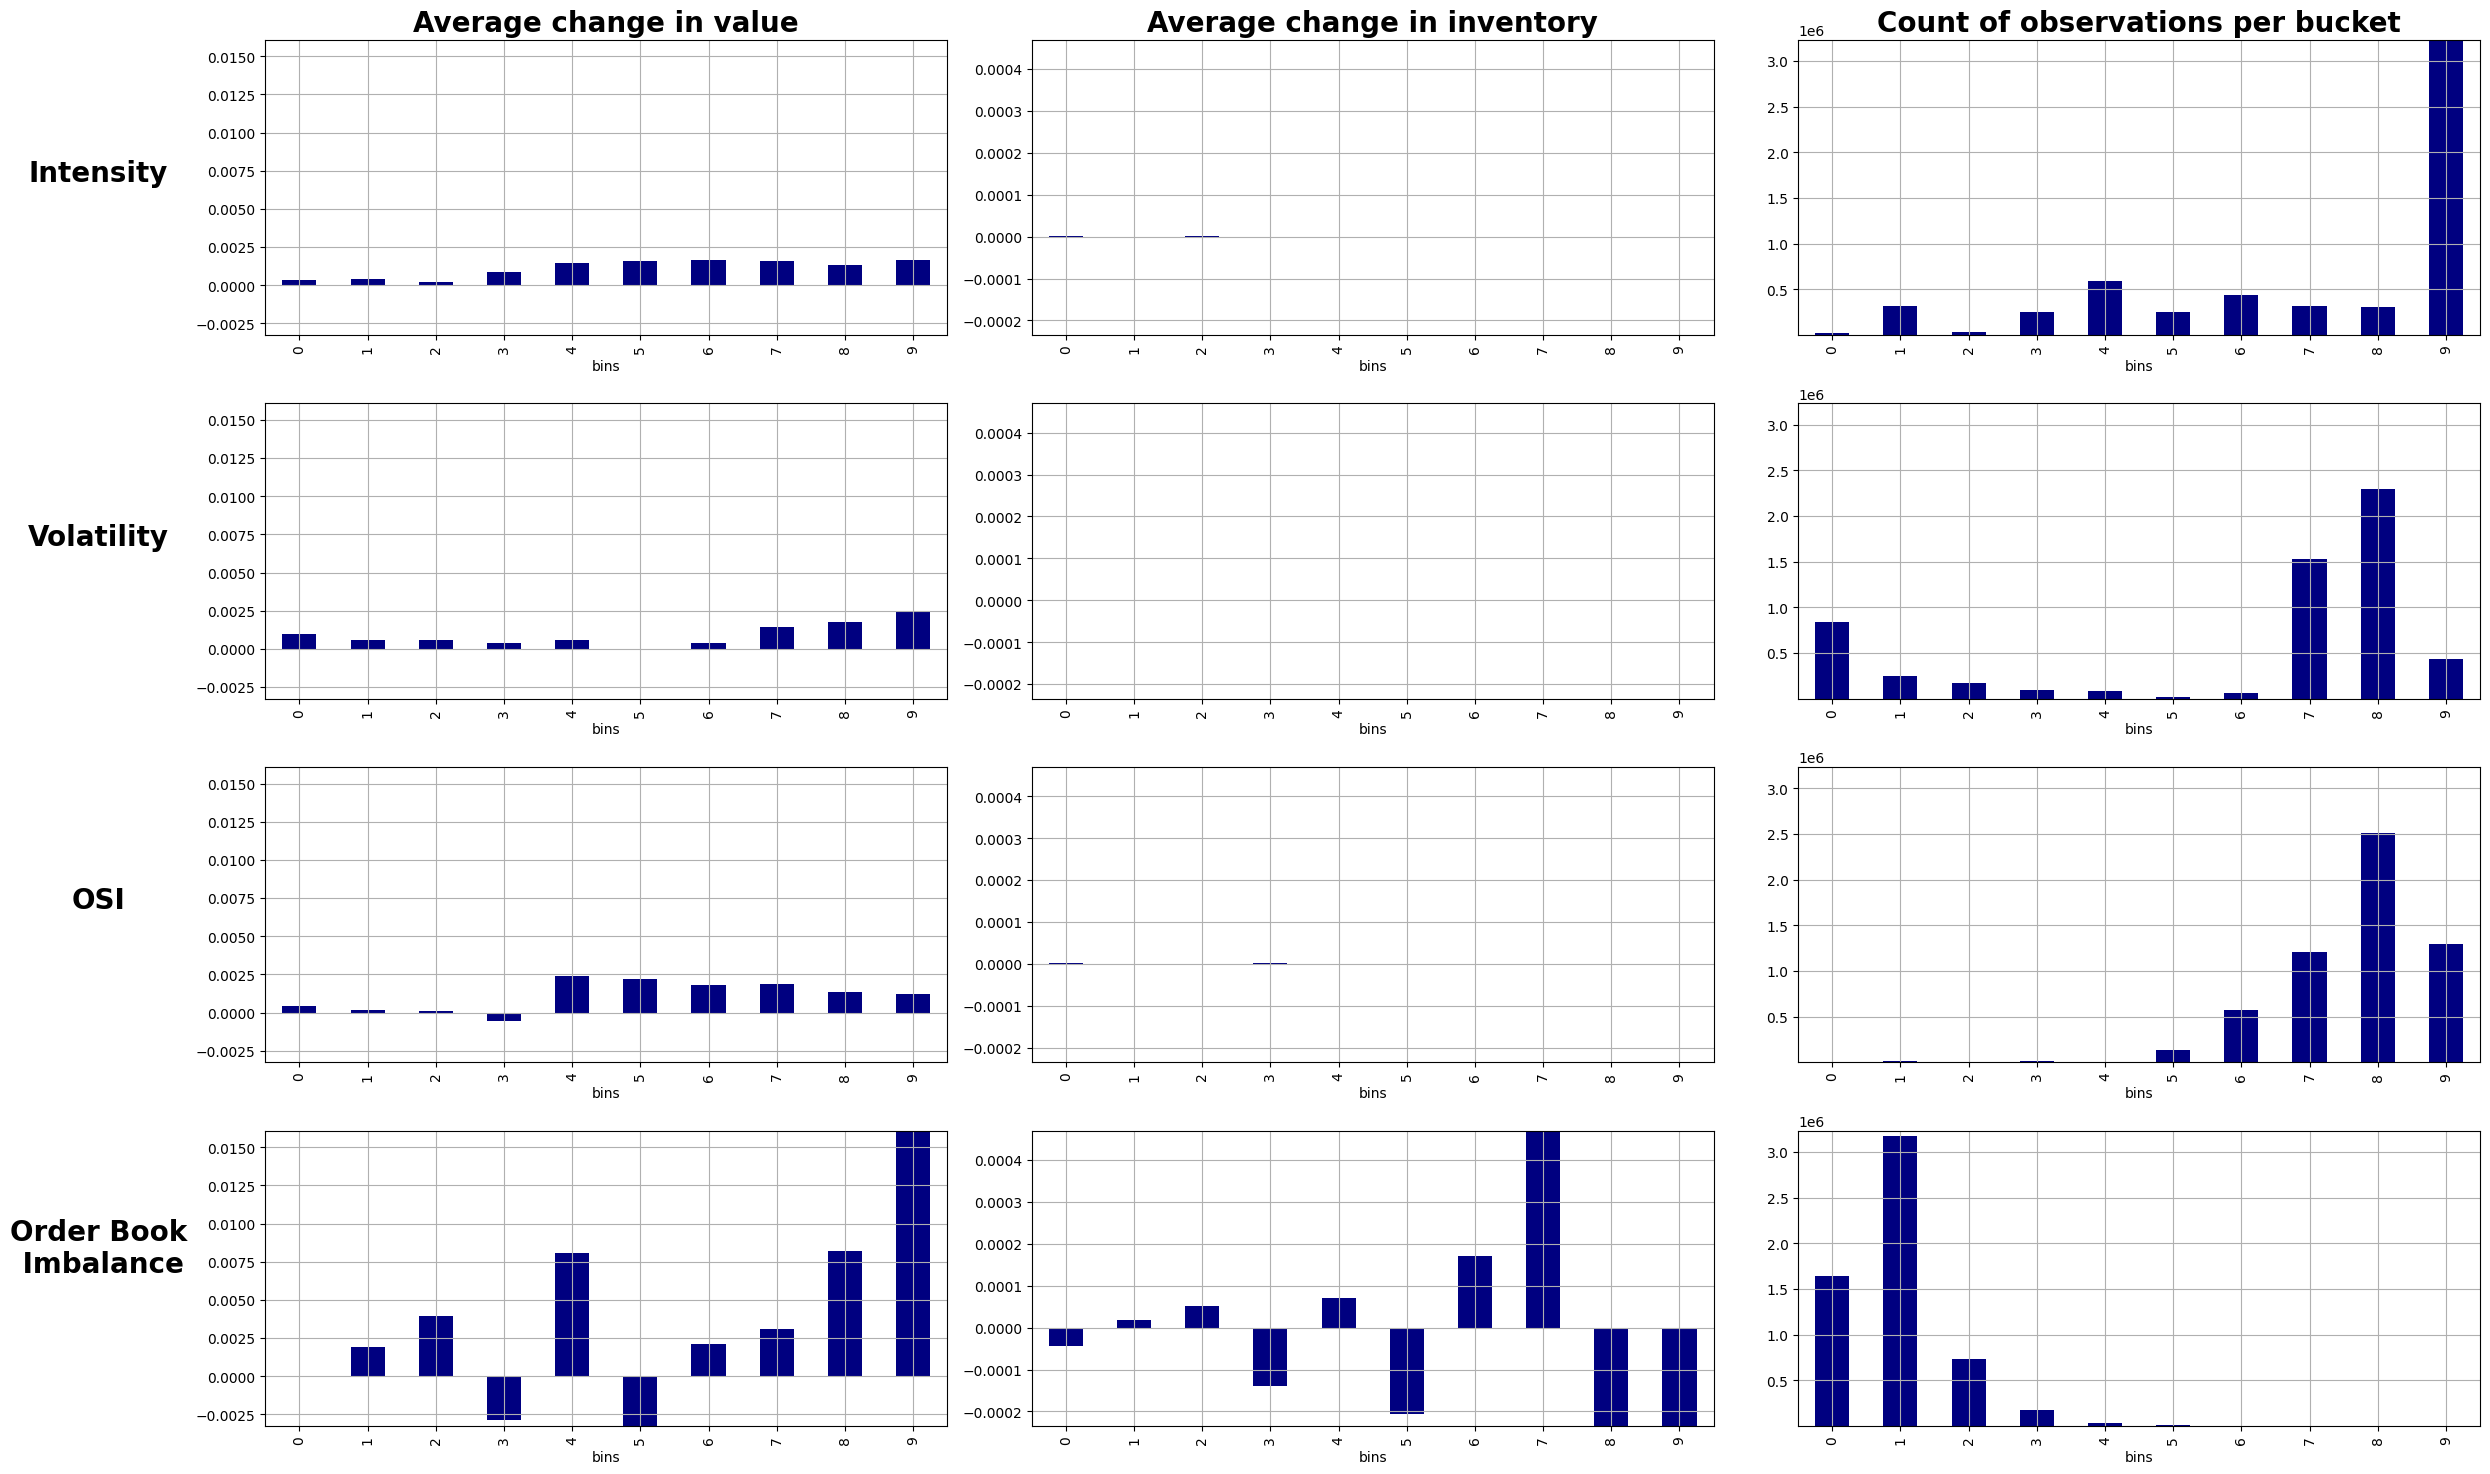

In [12]:
df_copy = df.copy()
variables = ["values", "inventory"]

df_copy['intensity_bins'] = pd.cut(df_copy['intensity'], bins=10)
df_copy['inventory_bins'] = pd.cut(df_copy['inventory'], bins=10)

variable_change = [f"{i}_change" for i in variables]
df_copy['values_change'] = df_copy['values'].diff()
df_copy['inventory_change'] = df_copy['inventory'].diff()
df_copy[variable_change]

explanatory = ["intensity", "volatility", "osi", "order_book_imbalance"]

for i in explanatory:
    df_copy[f"{i}_bins"], _ = pd.factorize(pd.cut(df_copy[i], bins=10))


df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]]
values_change_df = df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]].copy()
inventory_change_df = df_copy[["inventory_change"] + [f"{i}_bins" for i in explanatory]].copy()


average_values_df = pd.DataFrame()
count_values_df = pd.DataFrame()
for i in explanatory:
    values_change_df[f'{i}_bins'] = values_change_df[f'{i}_bins'].astype(str)    
    average_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").mean()['values_change']
    count_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").count()['values_change']


average_inventory_df = pd.DataFrame()
count_inventory_df = pd.DataFrame()
for i in explanatory:
    inventory_change_df[f'{i}_bins'] = inventory_change_df[f'{i}_bins'].astype(str)    
    average_inventory_df[i] = inventory_change_df[[f"{i}_bins", "inventory_change"]].groupby(f"{i}_bins").mean()['inventory_change']


average_values_df.rename_axis(index="bins", inplace=True)
average_inventory_df.rename_axis(index="bins", inplace=True)
count_values_df.rename_axis(index="bins", inplace=True)

cols = list(average_values_df.columns)
fig, axs = plt.subplots(len(cols), 3, figsize=(25, 15))

colors = ['#082567', '#0F52BA', '#1565C0', '#1E88E5']
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

values_max = average_values_df.max().max()
values_min = average_values_df.min().min()
inventory_max = average_inventory_df.max().max()
inventory_min = average_inventory_df.min().min()
count_max = count_values_df.max().max()
count_min = count_values_df.min().min()

# Column headers
col_titles = ['Average change in value', 'Average change in inventory', 'Count of observations per bucket']

# Set column titles
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col, fontsize=20, weight="bold")

# Set row labels
for ax, row in zip(axs[:,0], titles):
    ax.set_ylabel(row, rotation=0, fontsize=20, weight="bold", labelpad=70)

for count, i in enumerate(cols):
    average_values = average_values_df[i]
    average_inventory = average_inventory_df[i]
    count_df = count_values_df[i]

    # Remove x-axis label
    if count < len(cols) - 1:  # If it's not the last row
        axs[count, 0].set_xticklabels([])
        axs[count, 1].set_xticklabels([])
        axs[count, 2].set_xticklabels([])

    average_values.plot(kind='bar', ax=axs[count, 0], color="navy")
    axs[count, 0].grid(True)
    axs[count, 0].set_ylim([values_min, values_max])  # Set common y-axis limits

    average_inventory.plot(kind='bar', ax=axs[count, 1], color="navy")
    axs[count, 1].grid(True)
    axs[count, 1].set_ylim([inventory_min, inventory_max])  # Set common y-axis limits

    count_df.plot(kind='bar', ax=axs[count, 2], color="navy")
    axs[count, 2].grid(True)
    axs[count, 2].set_ylim([count_min, count_max])  # Set common y-axis limits

fig.tight_layout()
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables.png'))
plt.show()


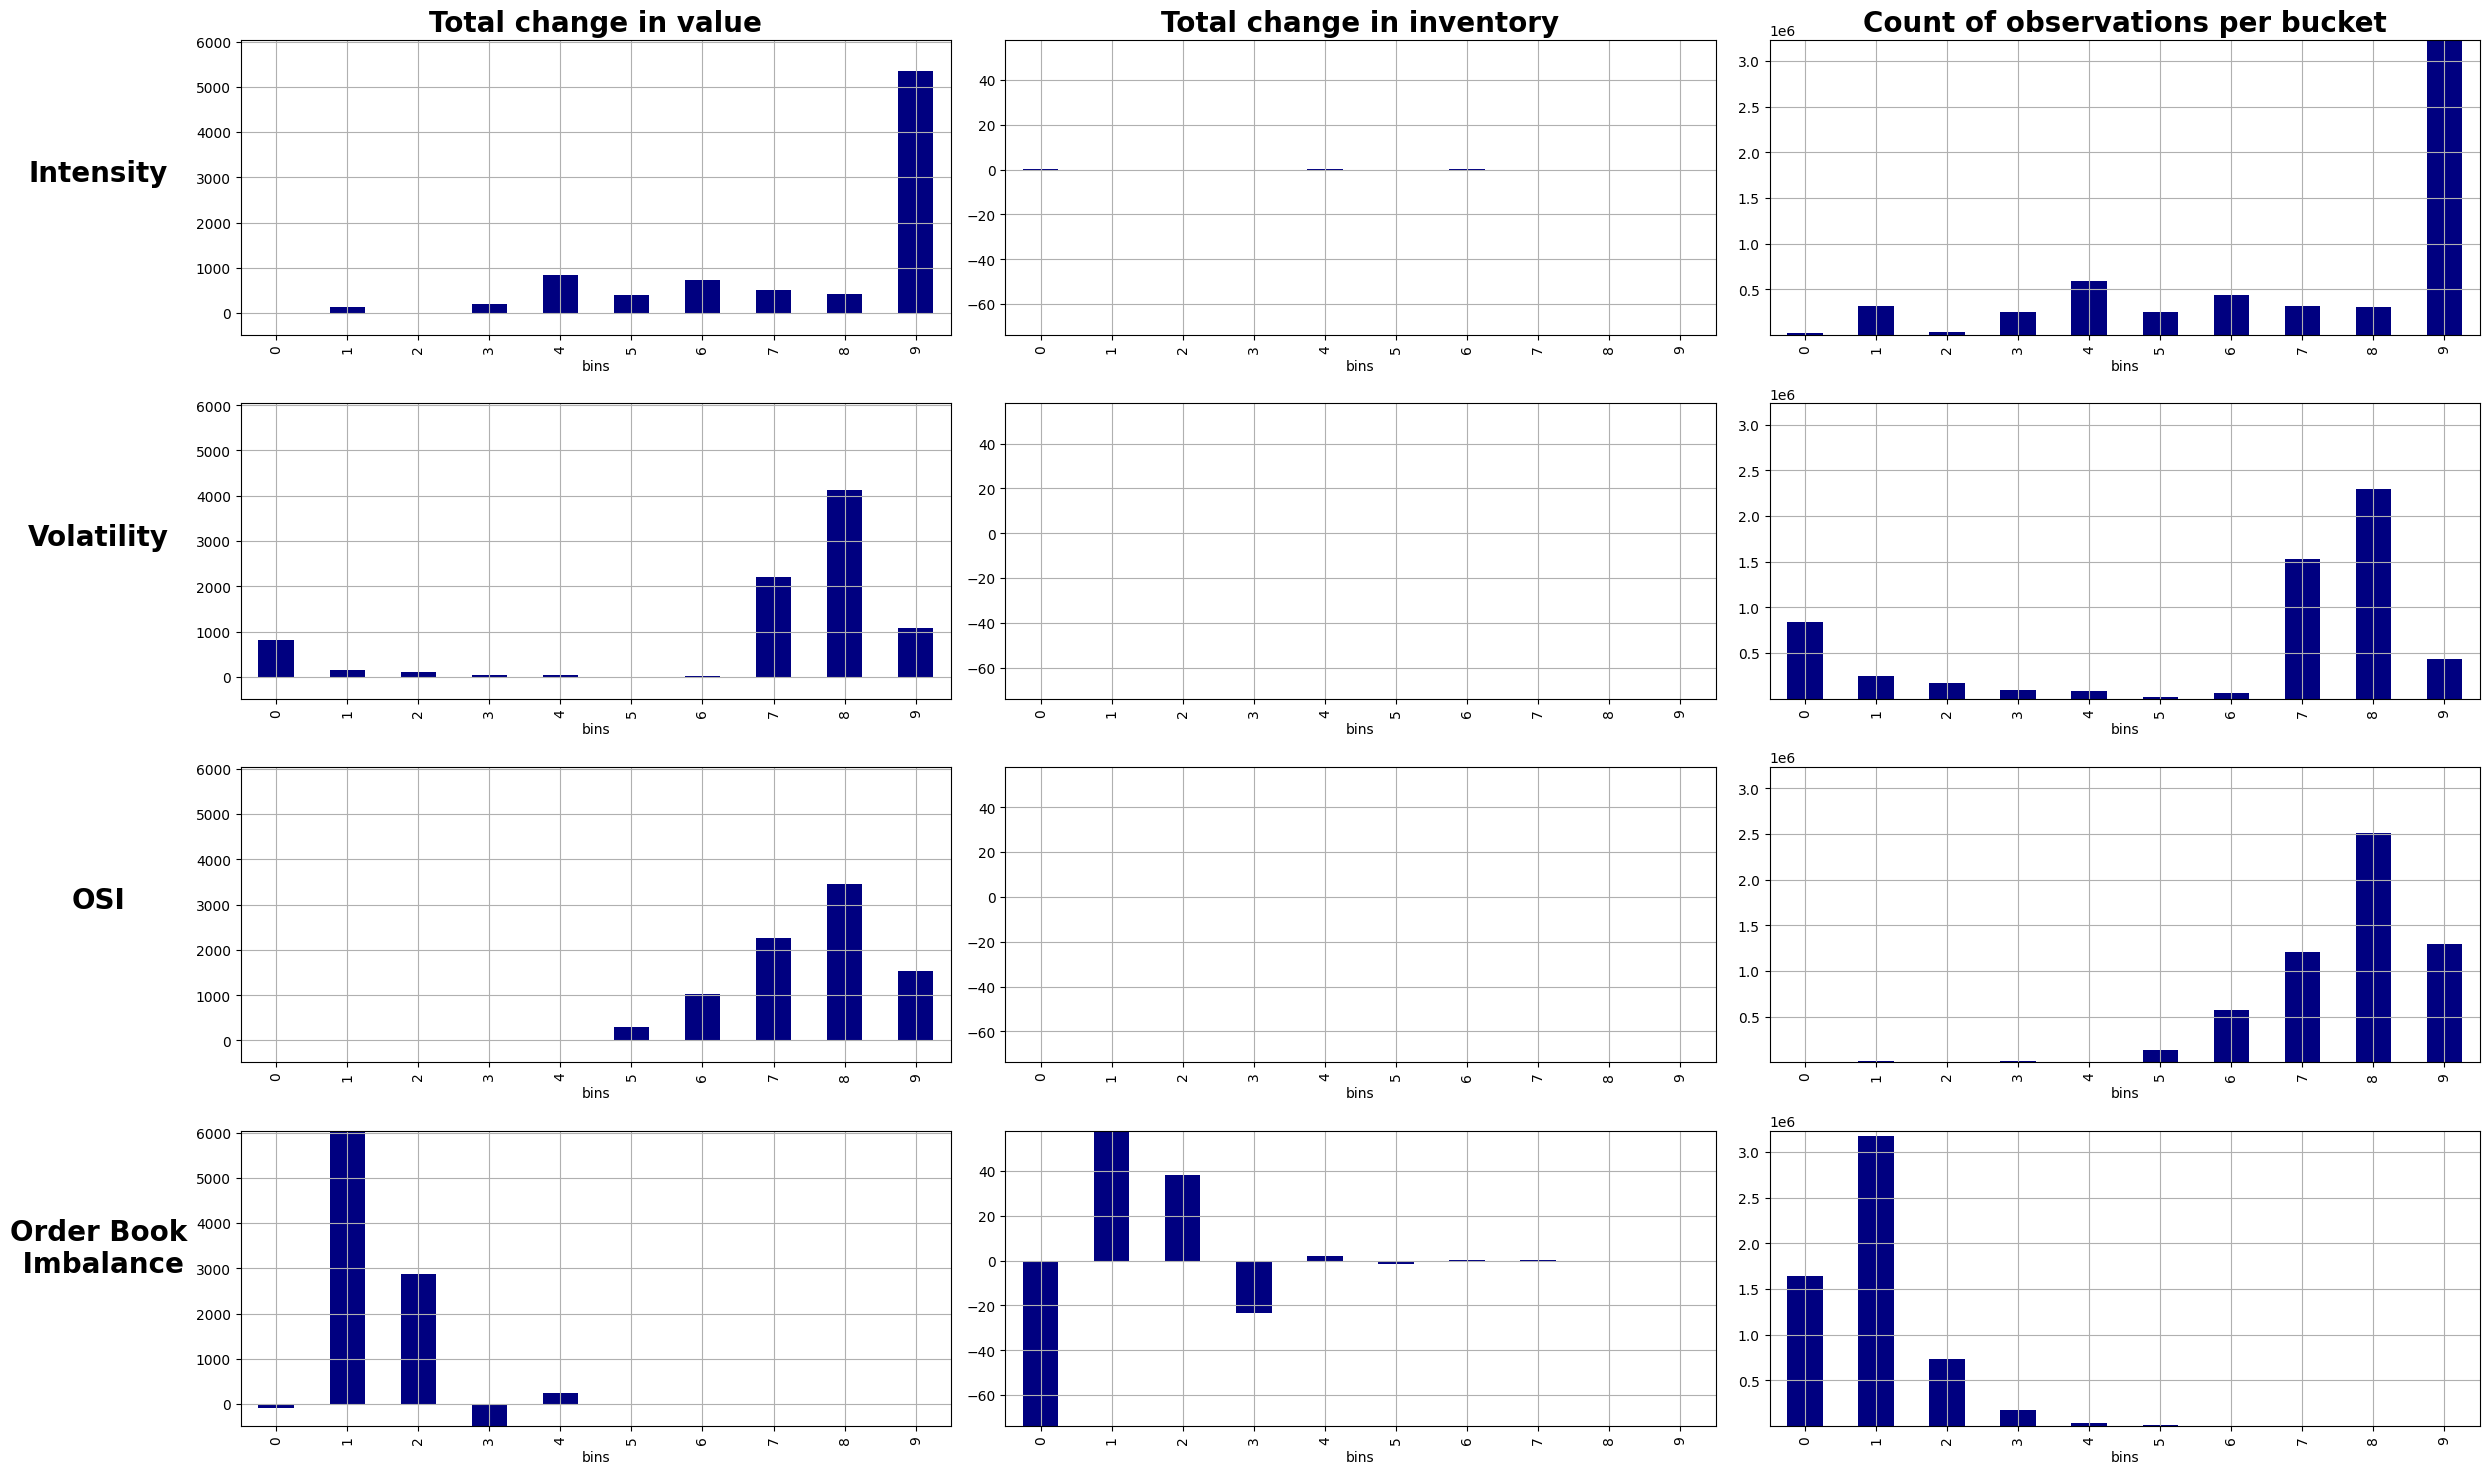

In [13]:
df_copy = df.copy()
variables = ["values", "inventory"]

df_copy['intensity_bins'] = pd.cut(df_copy['intensity'], bins=10)
df_copy['inventory_bins'] = pd.cut(df_copy['inventory'], bins=10)

variable_change = [f"{i}_change" for i in variables]
df_copy['values_change'] = df_copy['values'].diff()
df_copy['inventory_change'] = df_copy['inventory'].diff()
df_copy[variable_change]

explanatory = ["intensity", "volatility", "osi", "order_book_imbalance"]

for i in explanatory:
    df_copy[f"{i}_bins"], _ = pd.factorize(pd.cut(df_copy[i], bins=10))


df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]]
values_change_df = df_copy[["values_change"] + [f"{i}_bins" for i in explanatory]].copy()
inventory_change_df = df_copy[["inventory_change"] + [f"{i}_bins" for i in explanatory]].copy()


total_values_df = pd.DataFrame()
count_values_df = pd.DataFrame()
for i in explanatory:
    values_change_df[f'{i}_bins'] = values_change_df[f'{i}_bins'].astype(str)    
    total_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").sum()['values_change']
    count_values_df[i] = values_change_df[[f"{i}_bins", "values_change"]].groupby(f"{i}_bins").count()['values_change']


total_inventory_df = pd.DataFrame()
count_inventory_df = pd.DataFrame()
for i in explanatory:
    inventory_change_df[f'{i}_bins'] = inventory_change_df[f'{i}_bins'].astype(str)    
    total_inventory_df[i] = inventory_change_df[[f"{i}_bins", "inventory_change"]].groupby(f"{i}_bins").sum()['inventory_change']


total_values_df.rename_axis(index="bins", inplace=True)
total_inventory_df.rename_axis(index="bins", inplace=True)
count_values_df.rename_axis(index="bins", inplace=True)



cols = list(total_values_df.columns)
fig, axs = plt.subplots(len(cols), 3, figsize=(25, 15))

colors = ['#082567', '#0F52BA', '#1565C0', '#1E88E5']
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

values_max = total_values_df.max().max()
values_min = total_values_df.min().min()
inventory_max = total_inventory_df.max().max()
inventory_min = total_inventory_df.min().min()
count_max = count_values_df.max().max()
count_min = count_values_df.min().min()

# Column headers
col_titles = ['Total change in value', 'Total change in inventory', 'Count of observations per bucket']

# Set column titles
for ax, col in zip(axs[0], col_titles):
    ax.set_title(col, fontsize=20, weight="bold")

# Set row labels
for ax, row in zip(axs[:,0], titles):
    ax.set_ylabel(row, rotation=0, fontsize=20, weight="bold", labelpad=70)

for count, i in enumerate(cols):
    total_values = total_values_df[i]
    total_inventory = total_inventory_df[i]
    count_df = count_values_df[i]

    # Remove x-axis label
    if count < len(cols) - 1:  # If it's not the last row
        axs[count, 0].set_xticklabels([])
        axs[count, 1].set_xticklabels([])
        axs[count, 2].set_xticklabels([])

    total_values.plot(kind='bar', ax=axs[count, 0], color="navy")
    axs[count, 0].grid(True)
    axs[count, 0].set_ylim([values_min, values_max])  # Set common y-axis limits

    total_inventory.plot(kind='bar', ax=axs[count, 1], color="navy")
    axs[count, 1].grid(True)
    axs[count, 1].set_ylim([inventory_min, inventory_max])  # Set common y-axis limits

    count_df.plot(kind='bar', ax=axs[count, 2], color="navy")
    axs[count, 2].grid(True)
    axs[count, 2].set_ylim([count_min, count_max])  # Set common y-axis limits

fig.tight_layout()
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables_appendix.png'))
plt.show()


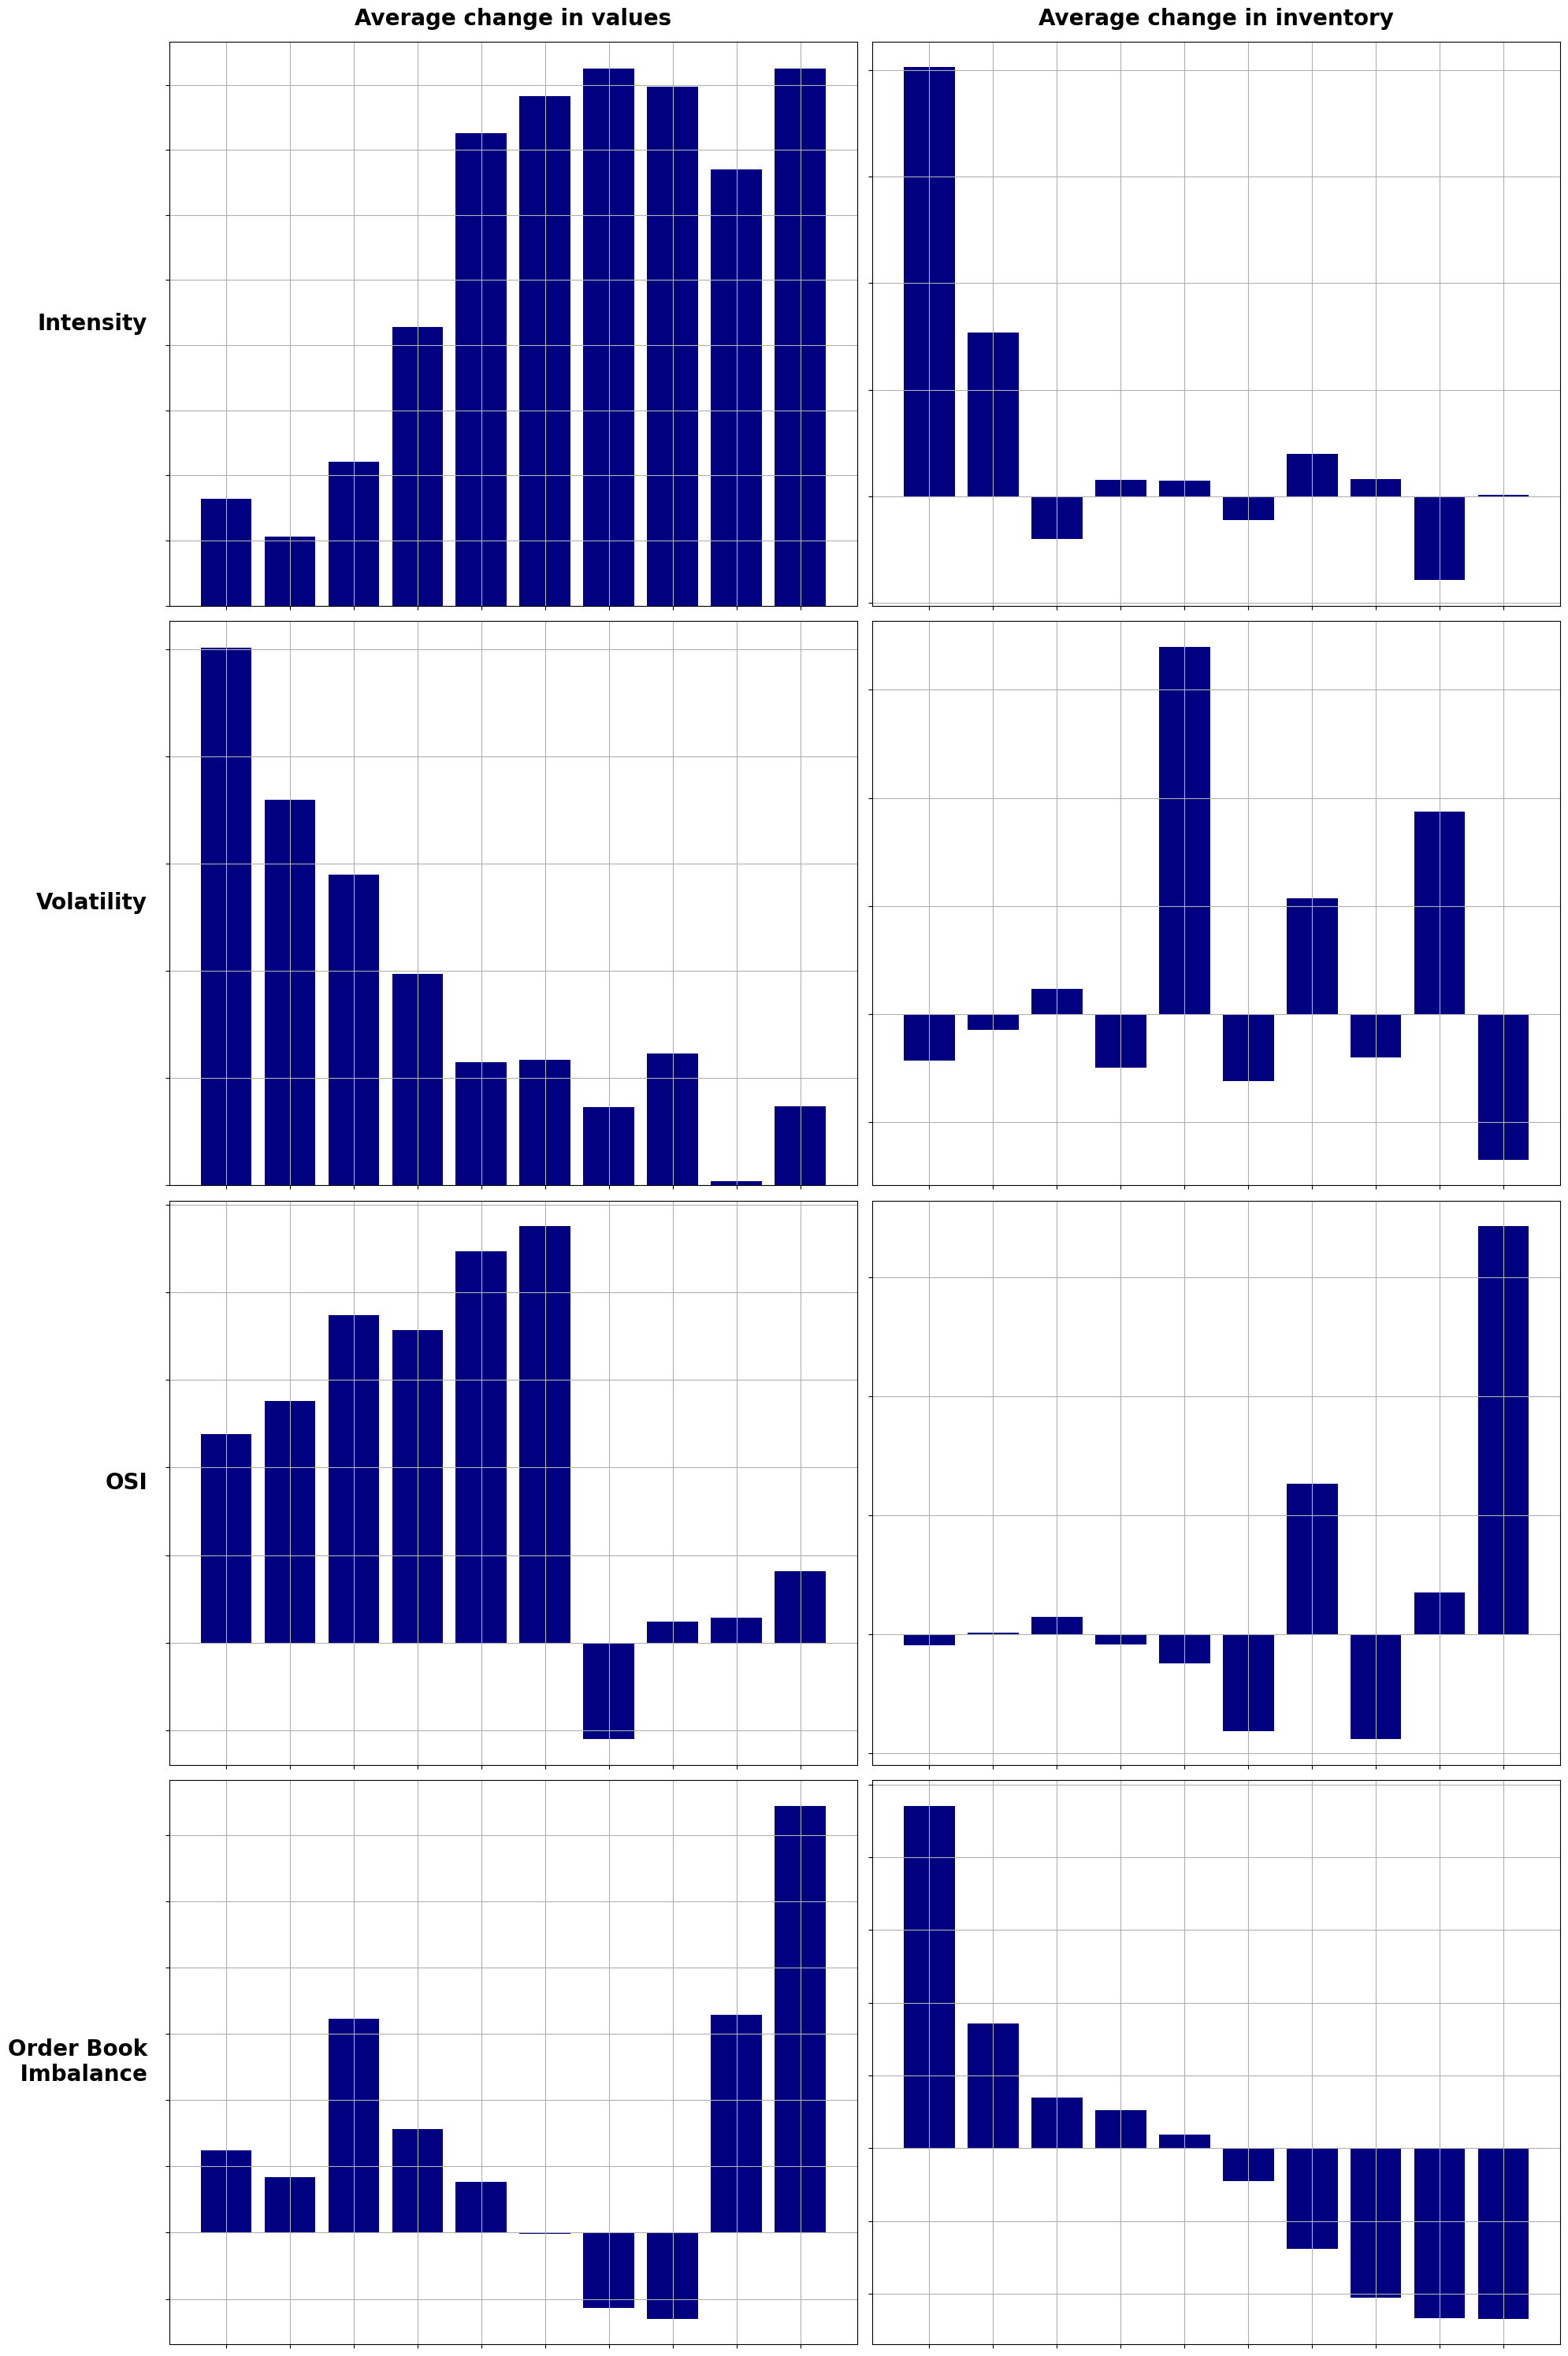

In [25]:
fig, axs = plt.subplots(4, 2, figsize=(20, 30))  # 4 rows and 3 columns

variables = ["intensity", "volatility", "osi", "order_book_imbalance"]
titles = ["Intensity", "Volatility", "OSI", "Order Book\n Imbalance"]

df_copy = df.copy()

for i, var in enumerate(variables):
    for j, col in enumerate(["values", "inventory"]):
        df_copy[f'{var}_bins'] = pd.cut(df_copy[var], bins=10)
        df_copy['value_change'] = df_copy[col].diff()
        df_copy['count'] = 1

        binned_value_change_mean = df_copy.groupby(f'{var}_bins')['value_change'].mean()
        binned_value_change_count = df_copy.groupby(f'{var}_bins')['count'].sum()
        axs[i, j].bar(binned_value_change_mean.index.astype(str), binned_value_change_mean, color='navy')  # Changed color to 'navy'
        axs[i, j].grid(True)
        axs[i, j].set_xticklabels([])  # Remove x-axis values
        axs[i, j].set_yticklabels([])  # Remove y-axis values


fontsize = 20  # Set the font size

for ax, col in zip(axs[0], ['Average change in values', 'Average change in inventory', 'Count of observations per bucket']):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 15),
                xycoords='axes fraction', textcoords='offset points',
                size=fontsize, 
                weight="bold", ha='center', va='baseline')  # Increased font size

for ax, row in zip(axs[:,0], titles):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size=fontsize, 
                weight="bold", ha='right', va='center')  # Increased font size

fig.tight_layout()
plt.savefig(os.path.join(visual_folder, 'inventory_change_by_variables_not_scaled.png'))
plt.show()

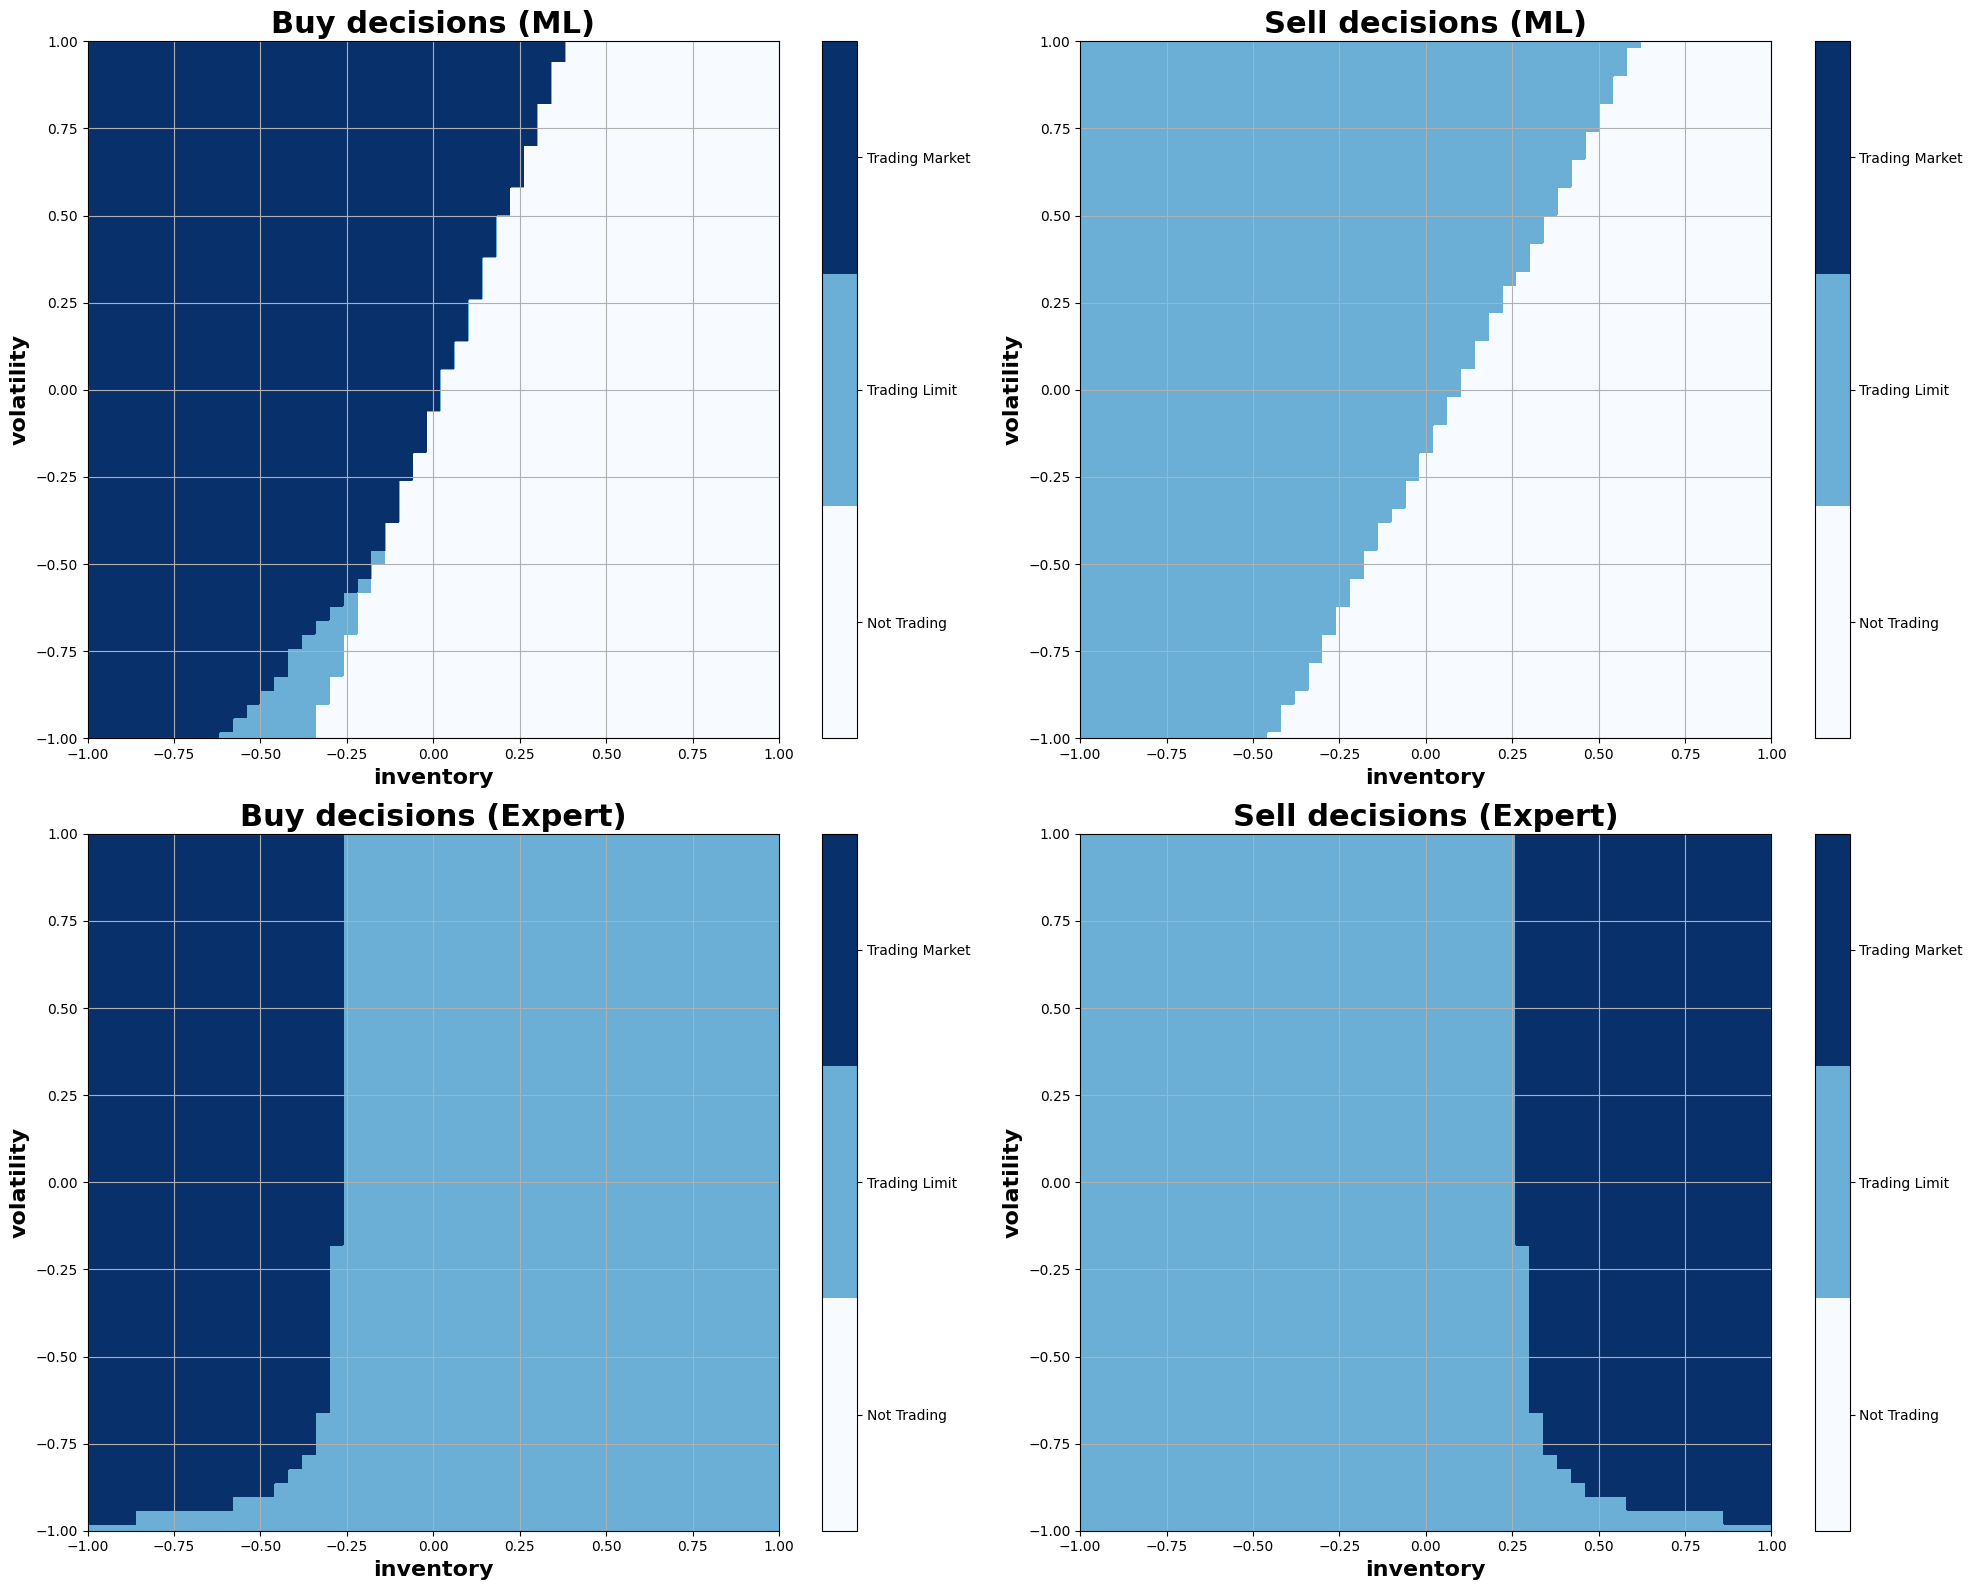

In [28]:
def create_decision_grid(df, bid_size_col, ask_size_col, bid_col, ask_col, title_suffix):
    df_buy = df.copy()
    df_buy['trading_market'] = (df[bid_size_col] != 0) & (df[bid_col] > 0)
    df_buy['trading_limit'] = (df[bid_size_col] != 0) & (df[bid_col] < 0)
    df_buy['not_trading'] = df[bid_size_col] == 0

    df_sell = df.copy()
    df_sell['trading_market'] = (df[ask_size_col] != 0) & (df[ask_col] < 0)
    df_sell['trading_limit'] = (df[ask_size_col] != 0) & (df[ask_col] > 0)
    df_sell['not_trading'] = df[ask_size_col] == 0

    return df_buy, df_sell

def plot_decision_grid(ax, df, x_column, y_column, title):
    Z = griddata((df[x_column], df[y_column]), df[choices].values.argmax(axis=1), (X, Y), method='nearest')

    cmap = plt.get_cmap('Blues', len(choices))  # Changed colormap to 'Pastel1'
    c = ax.contourf(X, Y, Z, levels=np.arange(len(choices) + 1) - 0.5, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.arange(len(choices)))
    cbar.set_ticklabels(['Not Trading', 'Trading Limit', 'Trading Market'])  # Changed labels
    # cbar.set_ticklabels(choices)
    ax.set_title(title, fontsize=22, fontweight='bold')
    ax.set_xlabel(x_column, fontsize=16, fontweight='bold')
    ax.set_ylabel(y_column, fontsize=16, fontweight='bold')
    ax.grid(True)



config = get_config("decision_grid", subdirectory=["research_configs"])
create_model_decision_grid(config)
df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")

resolution = 500
# define your x, y columns and choices
y_column = "volatility"
x_column = "inventory"
choices = ['not_trading', 'trading_limit', 'trading_market']

# columns for ML and Expert
columns_ml = [x_column, y_column, 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask']
columns_expert = [x_column, y_column, 'as_policy_bid_size', 'as_policy_ask_size', 'as_policy_bid', 'as_policy_ask']

# create decision grids
df_ml_buy, df_ml_sell = create_decision_grid(df[columns_ml], 'ml_policy_bid_size', 'ml_policy_ask_size', 'ml_policy_bid', 'ml_policy_ask', 'ML')
df_expert_buy, df_expert_sell = create_decision_grid(df[columns_expert], 'as_policy_bid_size', 'as_policy_ask_size', 'as_policy_bid', 'as_policy_ask', 'Expert')

x_range = np.linspace(df[x_column].min(), df[x_column].max(), resolution)
y_range = np.linspace(df[y_column].min(), df[y_column].max(), resolution)
X, Y = np.meshgrid(x_range, y_range)

fig, axs = plt.subplots(2, 2, figsize=(20, 16))

# plot decision grids
plot_decision_grid(axs[0, 0], df_ml_buy, x_column, y_column, 'Buy decisions (ML)')
plot_decision_grid(axs[0, 1], df_ml_sell, x_column, y_column, 'Sell decisions (ML)')
plot_decision_grid(axs[1, 0], df_expert_buy, x_column, y_column, 'Buy decisions (Expert)')
plot_decision_grid(axs[1, 1], df_expert_sell, x_column, y_column, 'Sell decisions (Expert)')

plt.tight_layout()
plt.savefig(os.path.join(visual_folder, 'decision_grid_comparison.png'))
plt.show()




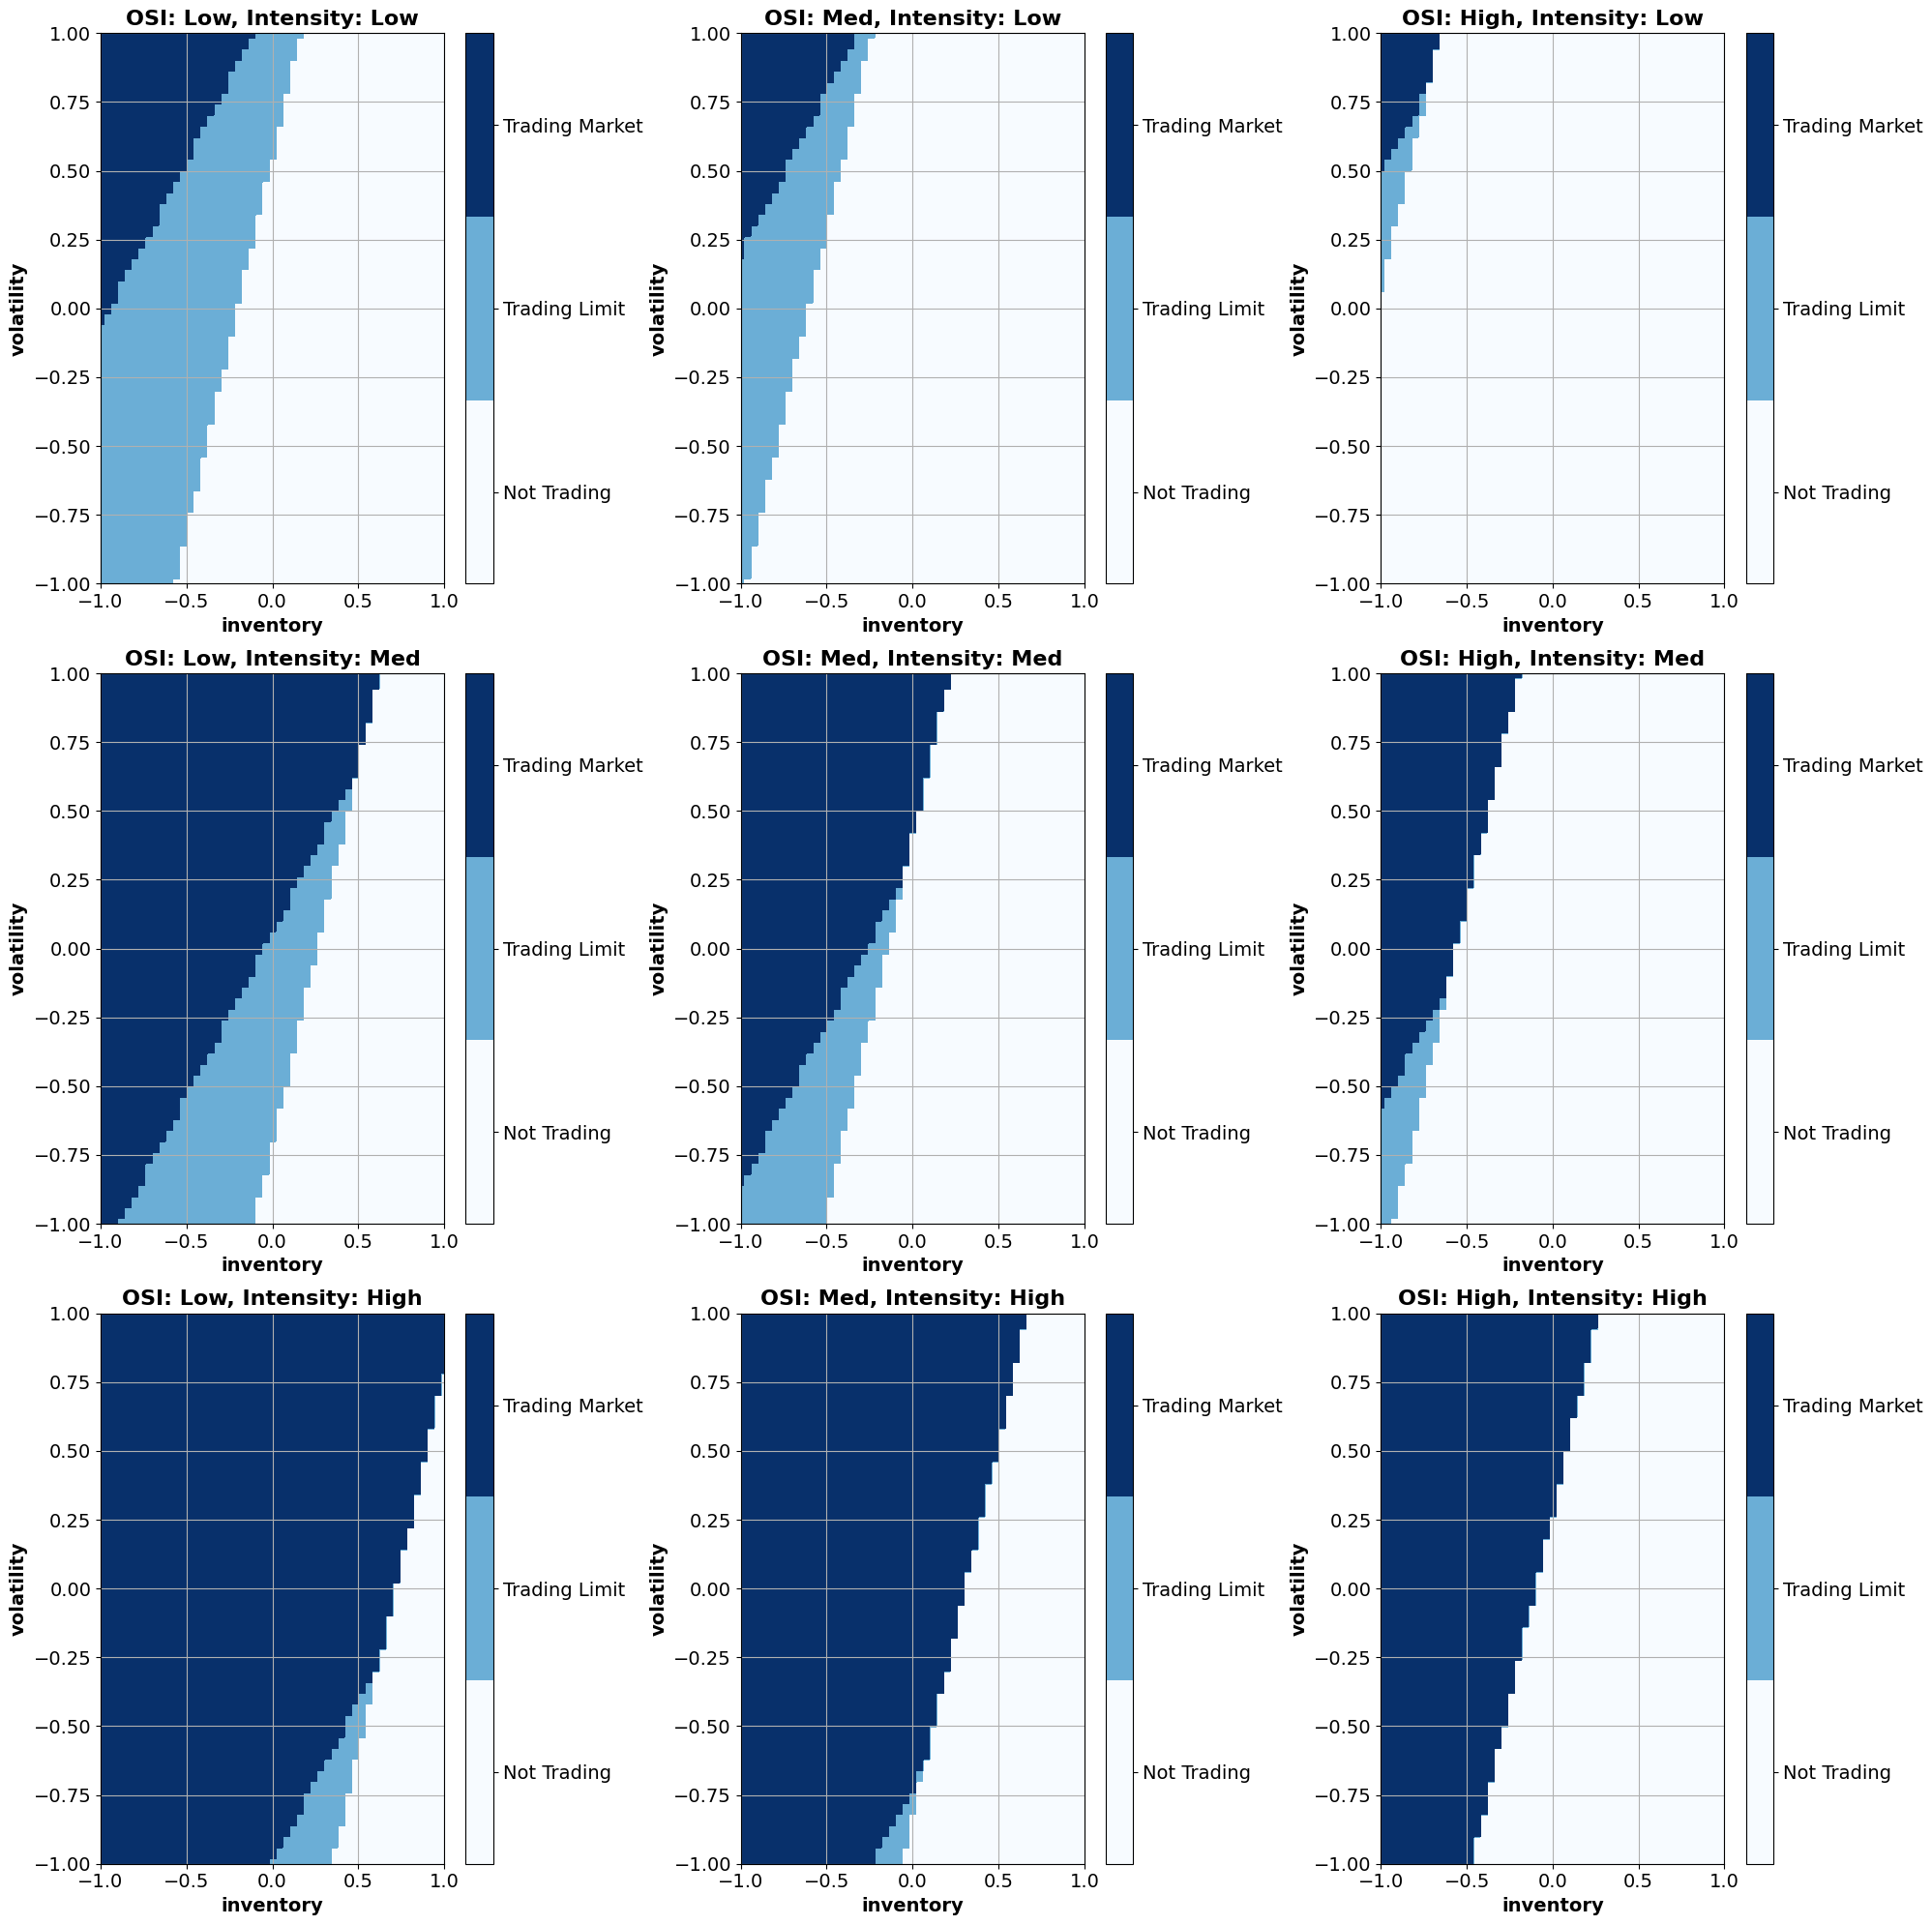

In [37]:
def plot_decision_grid(ax, df, x_column, y_column, title):
    Z = griddata((df[x_column], df[y_column]), df[choices].values.argmax(axis=1), (X, Y), method='nearest')

    cmap = plt.get_cmap('Blues', len(choices))
    c = ax.contourf(X, Y, Z, levels=np.arange(len(choices) + 1) - 0.5, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.arange(len(choices)))
    cbar.set_ticklabels(['Not Trading', 'Trading Limit', 'Trading Market'])  # Changed labels
    cbar.ax.tick_params(labelsize=14)  # Change tick label size on the colorbar
    ax.set_title(title, fontsize=16, fontweight='bold')  # Changed title font size and weight
    ax.set_xlabel(x_column, fontsize=14, fontweight='bold')  # Changed x label font size and weight
    ax.set_ylabel(y_column, fontsize=14, fontweight='bold')  # Changed y label font size and weight
    ax.grid(True)
    ax.tick_params(labelsize=14)  # Change tick label size

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
config = get_config("decision_grid", subdirectory=["research_configs"])

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, intensity in enumerate(list(value_mapping.keys())):
    for j, osi in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.intensity = intensity
        config.decision_grid.constant_values.osi = osi
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'OSI: {value_mapping[osi]}, Intensity: {value_mapping[intensity]}')

plt.tight_layout()
plt.savefig(os.path.join(visual_folder, 'decision_grid_matrix.png'))
plt.show()


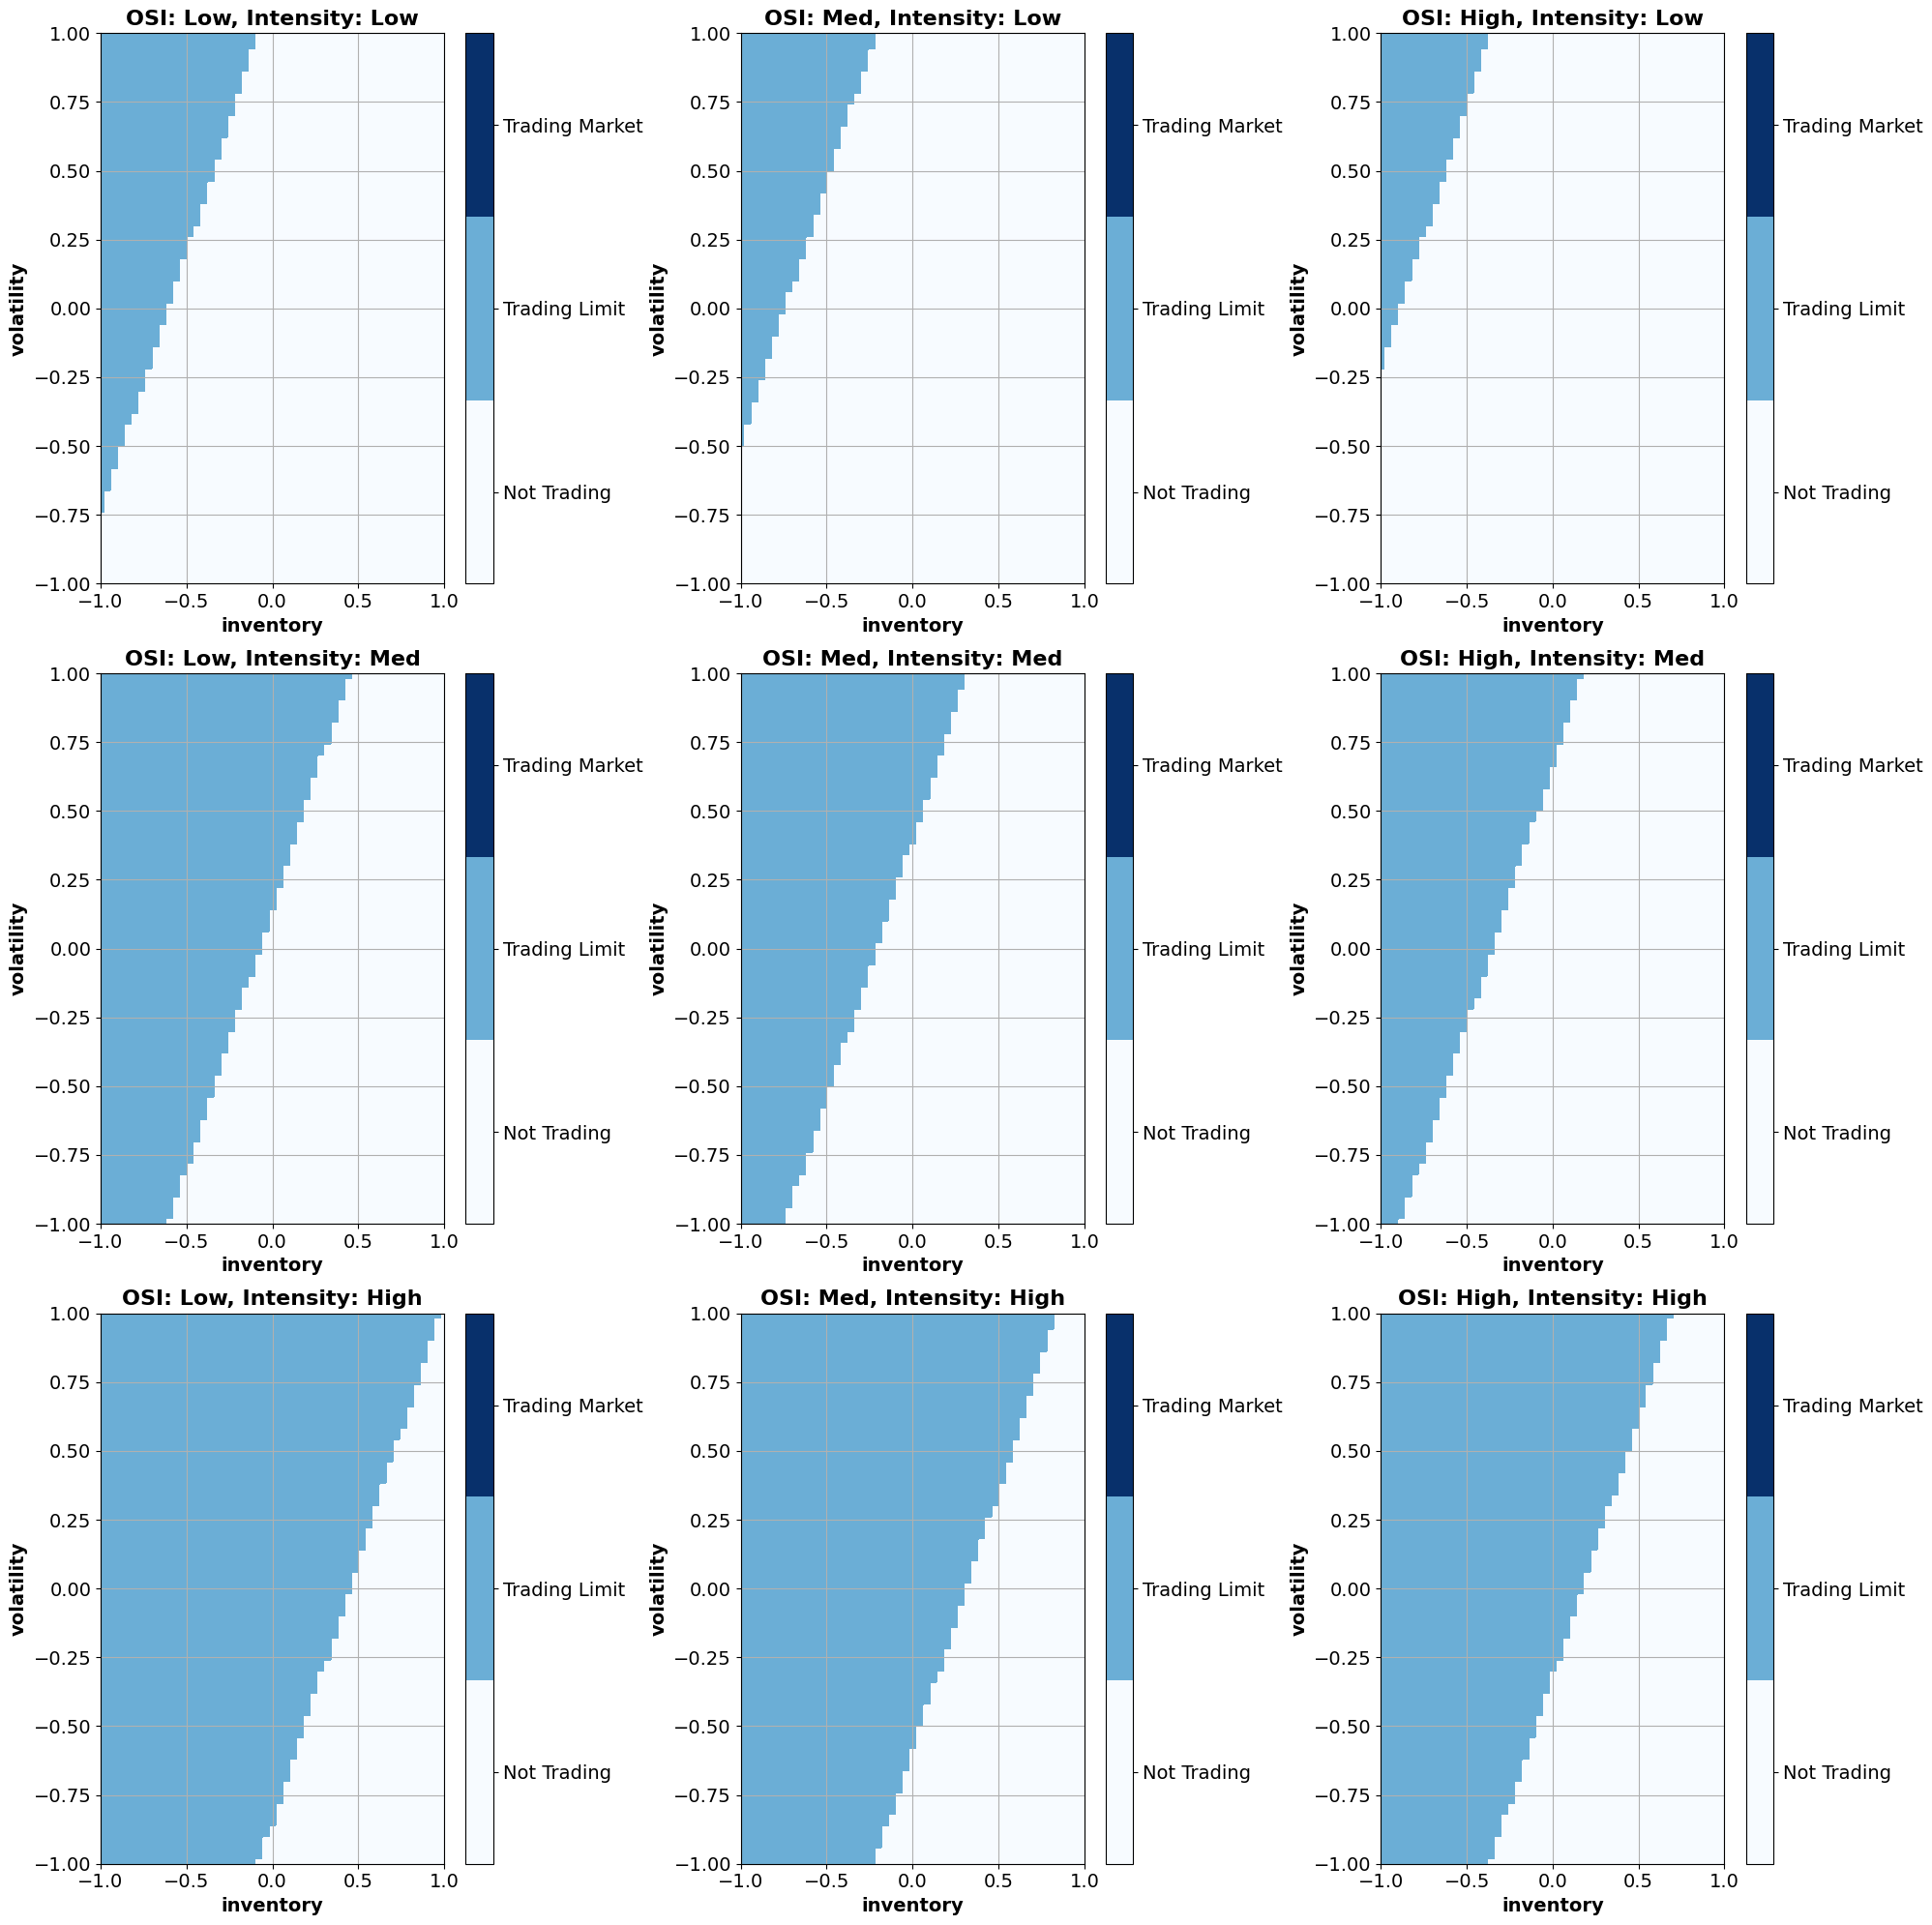

In [31]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
config = get_config("decision_grid", subdirectory=["research_configs"])

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, intensity in enumerate(list(value_mapping.keys())):
    for j, osi in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.intensity = intensity
        config.decision_grid.constant_values.osi = osi
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_sell = df.copy()
        df_sell['trading_market'] = (df.ml_policy_ask_size != 0) & (df.ml_policy_ask < 0)
        df_sell['trading_limit'] = (df.ml_policy_ask_size != 0) & (df.ml_policy_ask > 0)
        df_sell['not_trading'] = df.ml_policy_ask_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_sell, x_column, y_column, f'OSI: {value_mapping[osi]}, Intensity: {value_mapping[intensity]}')

plt.tight_layout()
plt.savefig(os.path.join(visual_folder, 'decision_grid_matrix_sell.png'))
plt.show()

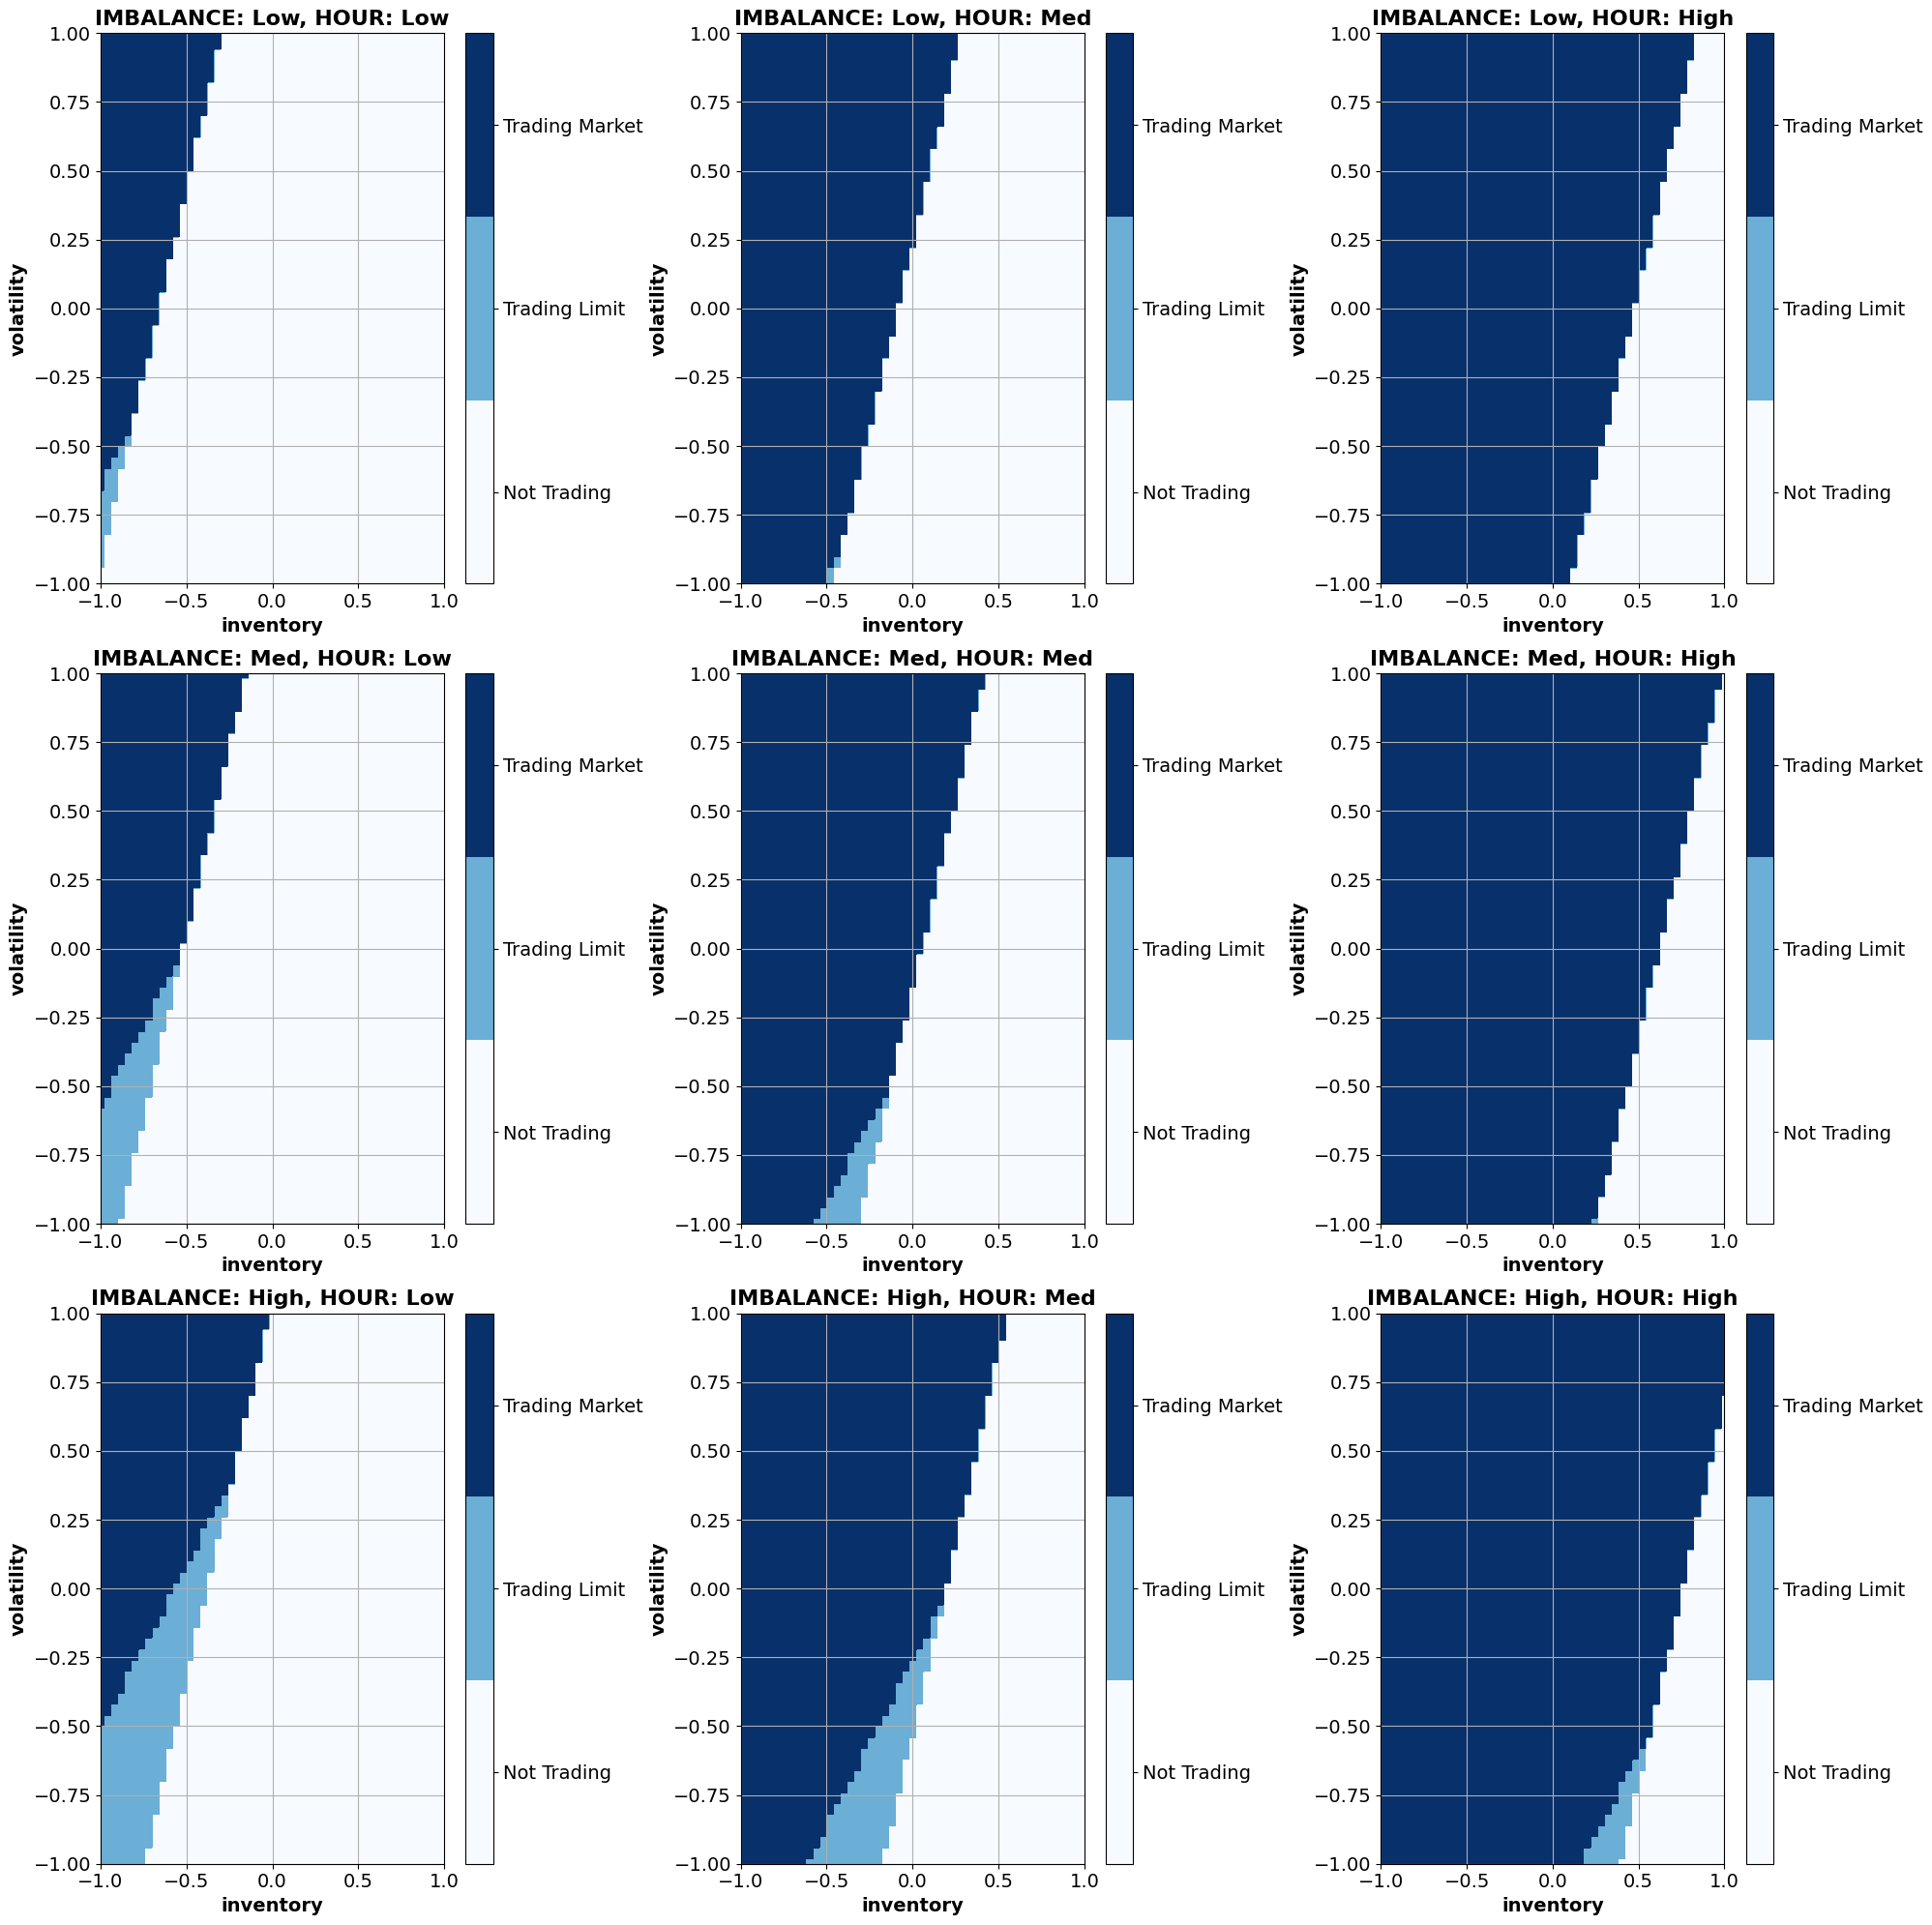

In [38]:
# remember config!!!!!

def plot_decision_grid(ax, df, x_column, y_column, title):
    Z = griddata((df[x_column], df[y_column]), df[choices].values.argmax(axis=1), (X, Y), method='nearest')

    cmap = plt.get_cmap('Blues', len(choices))
    c = ax.contourf(X, Y, Z, levels=np.arange(len(choices) + 1) - 0.5, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.arange(len(choices)))
    cbar.set_ticklabels(['Not Trading', 'Trading Limit', 'Trading Market'])  # Changed labels
    cbar.ax.tick_params(labelsize=14)  # Change tick label size on the colorbar
    ax.set_title(title, fontsize=16, fontweight='bold')  # Changed title font size and weight
    ax.set_xlabel(x_column, fontsize=14, fontweight='bold')  # Changed x label font size and weight
    ax.set_ylabel(y_column, fontsize=14, fontweight='bold')  # Changed y label font size and weight
    ax.grid(True)
    ax.tick_params(labelsize=14)  # Change tick label size

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
config = get_config("decision_grid", subdirectory=["research_configs"])

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, order_book_imbalance in enumerate(list(value_mapping.keys())):
    for j, current_hour in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.order_book_imbalance = order_book_imbalance
        config.decision_grid.constant_values.current_hour = current_hour
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'IMBALANCE: {value_mapping[order_book_imbalance]}, HOUR: {value_mapping[current_hour]}')

plt.tight_layout()
plt.savefig(os.path.join(visual_folder, 'decision_grid_matrix_imbalance_hour.png'))
plt.show()


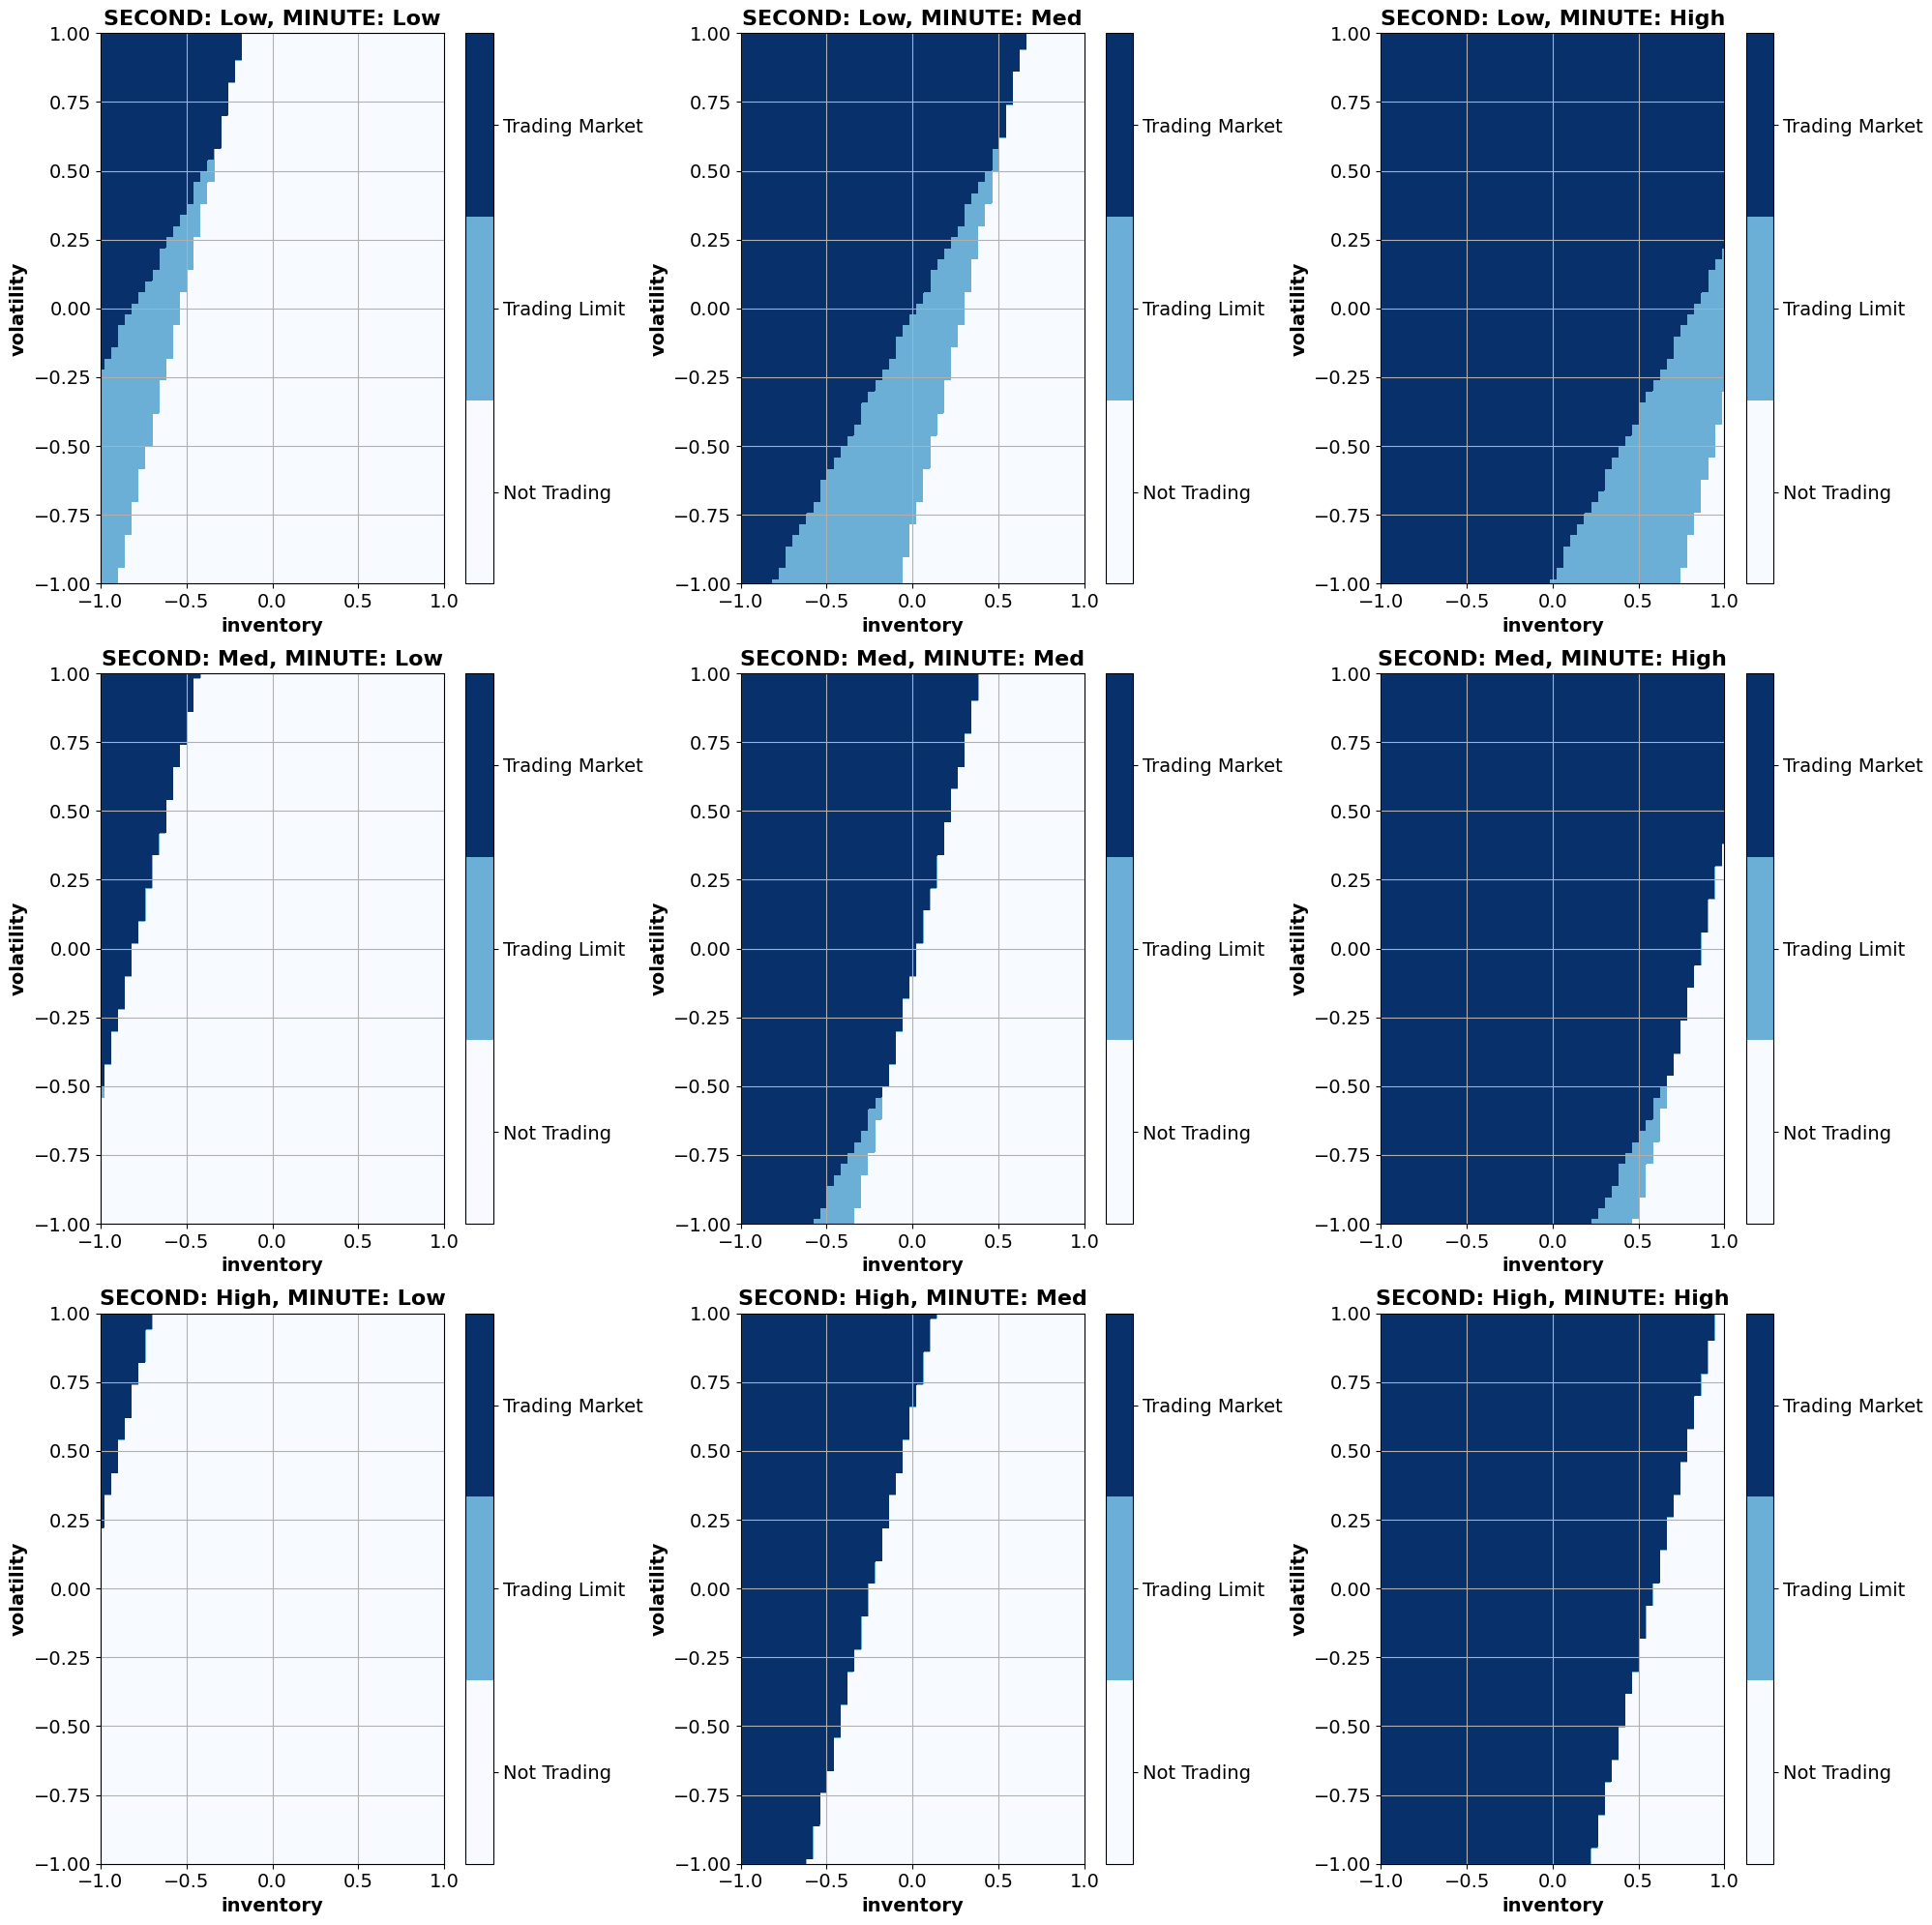

In [39]:
# remember config!!!!!

def plot_decision_grid(ax, df, x_column, y_column, title):
    Z = griddata((df[x_column], df[y_column]), df[choices].values.argmax(axis=1), (X, Y), method='nearest')

    cmap = plt.get_cmap('Blues', len(choices))
    c = ax.contourf(X, Y, Z, levels=np.arange(len(choices) + 1) - 0.5, cmap=cmap)
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_ticks(np.arange(len(choices)))
    cbar.set_ticklabels(['Not Trading', 'Trading Limit', 'Trading Market'])  # Changed labels
    cbar.ax.tick_params(labelsize=14)  # Change tick label size on the colorbar
    ax.set_title(title, fontsize=16, fontweight='bold')  # Changed title font size and weight
    ax.set_xlabel(x_column, fontsize=14, fontweight='bold')  # Changed x label font size and weight
    ax.set_ylabel(y_column, fontsize=14, fontweight='bold')  # Changed y label font size and weight
    ax.grid(True)
    ax.tick_params(labelsize=14)  # Change tick label size

fig, axs = plt.subplots(3, 3, figsize=(20, 20))
config = get_config("decision_grid", subdirectory=["research_configs"])

value_mapping = {-0.9: 'Low', 0: 'Med', 0.9: 'High'}

# Iterate over intensity and osi values
for i, order_book_imbalance in enumerate(list(value_mapping.keys())):
    for j, current_hour in enumerate(list(value_mapping.keys())):
        # Update config with current intensity and osi
        config.decision_grid.constant_values.current_second = order_book_imbalance
        config.decision_grid.constant_values.current_minute = current_hour
        # Generate the decision grid
        create_model_decision_grid(config)
        # Load the results
        df = pd.read_csv("/Users/juusoahlroos/Documents/own/gradu/parsed_data/results/decision_grid.csv")
        
        # Prepare df_buy (assuming the logic remains the same)
        df_buy = df.copy()
        df_buy['trading_market'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid > 0)
        df_buy['trading_limit'] = (df.ml_policy_bid_size != 0) & (df.ml_policy_bid < 0)
        df_buy['not_trading'] = df.ml_policy_bid_size == 0

        # Plot the decision grid for the current subplot
        plot_decision_grid(axs[i, j], df_buy, x_column, y_column, f'SECOND: {value_mapping[order_book_imbalance]}, MINUTE: {value_mapping[current_hour]}')

plt.tight_layout()
plt.savefig(os.path.join(visual_folder, 'decision_grid_matrix_second_minute.png'))
plt.show()
